In [1]:
"""
Titanic Survival Prediction - Kaggle Competition
Author: Kristiyan Bonev
Updated: November 2025

This notebook provides a comprehensive analysis of the Titanic dataset with:
- Exploratory Data Analysis (EDA)
- Advanced Feature Engineering
- Multiple Model Comparisons with Cross-Validation
- Hyperparameter Tuning via GridSearch
- Ensemble Methods & Voting Classifiers
- SHAP Analysis for Model Explainability
- Production-Ready ML Pipeline

For production deployment, see src/pipeline/train_pipeline.py
"""

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    f1_score, 
    classification_report,
    accuracy_score,
    roc_auc_score
)

# Add src to path for importing custom modules
sys.path.append(str(Path.cwd().parent))

# Import notebook-specific configuration
from src import notebook_config as config

# Import utility functions
from src.utils import (
    set_seeds,
    evaluate_models_cv,
    save_model_pickle,
    load_model_pickle,
    generate_kaggle_submission,
    optimise_models,
    get_cv_scores_detailed
)

# Import visualization functions
from src.visualization import (
    set_plot_style,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_model_comparison,
    plot_feature_importance,
    plot_cv_score_distribution,
    plot_precision_recall_curve
)

# Set random seeds for reproducibility
set_seeds(config.RANDOM_SEED)
print(f"✓ Random seed set to {config.RANDOM_SEED} for reproducibility")

# Set visualization style
set_plot_style()
print("✓ Visualization style configured")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("\n" + "="*60)
print("TITANIC SURVIVAL PREDICTION")
print("="*60)
print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__ if 'sklearn' in dir() else 'N/A'}")
print("="*60 + "\n")


d:\Programming\Repositories\Titanic-Machine-Learning-from-Disaster\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[ 2025-11-05 17:37:57,745 ] 344 root - INFO - Random seeds set to 42
[ 2025-11-05 17:37:57,745 ] 344 root - INFO - Random seeds set to 42


✓ Random seed set to 42 for reproducibility
✓ Visualization style configured

TITANIC SURVIVAL PREDICTION
Python version: 3.13.3
Pandas version: 2.3.3
NumPy version: 1.26.4
Scikit-learn version: N/A



## Project Planning

Let's outline the main steps of the project:
- Understanding the nature of the data .info() .describe()
- Exploratory analysis - histograms, boxplots and value counts
- Deal with missing data
- Check metrics correlation
- Themes to look into:
  - Level of wealth as a predictor
  - Location of cabin as a predictor
  - Age
  - Title
- Feature engineering
- Data preprocessing and scaling
- Baseline models
- Trained models
- Comparison.

## Configuration & Setup

**Reproducibility Settings:**
- Random Seed: 42 (set across numpy, random, sklearn)
- Cross-Validation: Stratified 5-Fold (handles class imbalance)
- Primary Metric: Accuracy (Kaggle competition metric)
- Secondary Metric: F1-weighted (better for imbalanced classes)

**Class Imbalance Handling:**
- ✓ **Stratified K-Fold CV** - Maintains class distribution across folds
- ✓ **Weighted F1 Score** - Accounts for minority class importance
- ✓ **Comprehensive Metrics** - Precision, Recall, ROC-AUC for full picture

**Key Improvements in This Version:**
- ✓ Full reproducibility with fixed random seeds
- ✓ Stratified cross-validation for imbalanced data
- ✓ Comprehensive evaluation metrics (accuracy, F1, ROC-AUC)
- ✓ Advanced visualizations
- ✓ Modular code structure with reusable utilities
- ✓ Modern Python best practices (type hints, docstrings)
- ✓ Feature importance analysis
- ✓ SHAP explainability
- ✓ Production-ready ML pipeline

<div align="center">
  <h3>Data Dictionary</h3>
</div>

| Variable  | Definition                | Key                                       |
|-----------|---------------------------|-------------------------------------------|
| survival  | Survival                  | 0 = No, 1 = Yes                           |
| pclass    | Ticket class              | 1 = 1st, 2 = 2nd, 3 = 3rd                 |
| sex       | Sex                       |                                           |
| Age       | Age in years              |                                           |
| sibsp     | # of siblings/spouses     |                                           |
| parch     | # of parents/children     |                                           |
| ticket    | Ticket number             |                                           |
| fare      | Passenger fare            |                                           |
| cabin     | Cabin number              |                                           |
| embarked  | Port of Embarkation       | C = Cherbourg, Q = Queenstown, S = Southampton |


### Data import

For this analysis, I will be exclusively working with the Training set. The training dataset will be used for validation as well. The final predictions for the Kaggle submissions will of course be done on the provided test dataset as per the competition's rules. I'll be doing the initial data analysis on the combined data which I'll differentiate with the use of a train/test flag in a new column.

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([train, test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

## 1. Data Exploration

**For Numeric Data:**
   - Histograms to explore distribution;
   - Correlation plots;
   - Pivot tables to try and understand survival rate across numeric variables;

**For Categorical Data:**
   - Plotting bar charts to explore balance of classes
   - Pivot tables again with the same goal of understanding the relation to survival rate

In [3]:
# Let's start with an overview of the train data:
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1


In [4]:
# Listing Numerical columns
cols = train.columns
num_cols = list(train.select_dtypes('number'))
print(num_cols)

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'train_test']


In [5]:
# Listing Categorical columns
cat_cols = list(set(cols) - set([str(col) for col in num_cols]))
print(cat_cols)

['Name', 'Embarked', 'Cabin', 'Ticket', 'Sex']


In [6]:
# A look at feature datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


##### Two colums stand out:
- Cabin is mostly null values which will need to be looked into and dealt with
- Age has a significant number of null vlaues as well which will also need to be investigated

In [7]:
# An overview of the central tendencies of the numeric data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [8]:
# Separating the numeric and categorical columns as each will require a separate approach
df_numeric = train[['Age','SibSp','Parch','Fare']]
df_categorical = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

### 1.1 Numeric Features Exploration

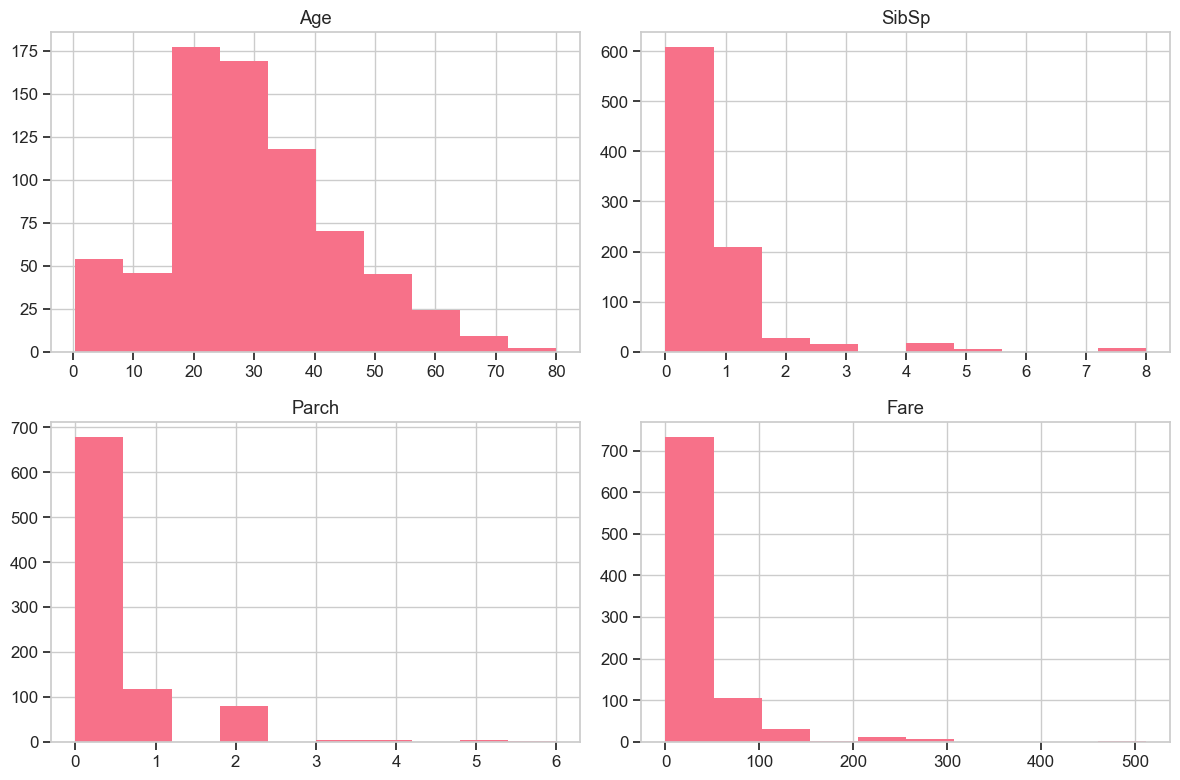

In [9]:
# Creating a grid of subplots for the numeric columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  # Flatten 2D array to 1D

# Plot each histogram in a subplot
for i, col in enumerate(df_numeric.columns):
    plt.sca(axes[i])
    plt.hist(df_numeric[col])
    plt.title(col)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

We have a normal distribution for the age column. The rest are all good candidates for normalization since they are skewed quite heavily.

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

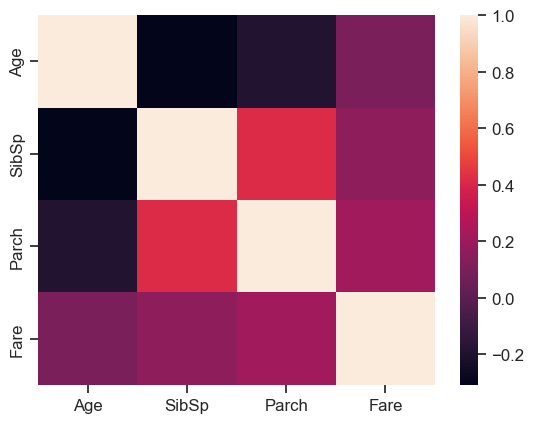

In [10]:
# A look at the correlation of our numeric columns
print(df_numeric.corr())
sns.heatmap(df_numeric.corr())

Here we can see that Parch and SibSp has a higher correlation, which generally makes sense since Parents are more likely to travel with their multiple kids and spouses tend to travel together.

In [11]:
# A look at survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(
    data = train,
    values = ['Age', 'SibSp', 'Parch', 'Fare'],
    index = 'Survived'
)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


There are a few interesting aspects to this:
- The average age of survivors is 28, so young people tend to have a better chance;
-  People who paid higher fare rates were more likely to survive, more than double. This might be the people traveling in first-clas,.tThus the rich survive. Higher class cabins were higher up on the ship;.-
Travelling with parents shows a significant correlation. Well done, parents on the Titanic;e- Having siblings looks to not be an advantage;ing

### 1.2 Categorical Features Exploration

[ 2025-11-05 17:37:58,451 ] 224 matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[ 2025-11-05 17:37:58,455 ] 224 matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[ 2025-11-05 17:37:58,473 ] 224 matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[ 2025-11-05 17:37:58,455 ] 224 matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotti

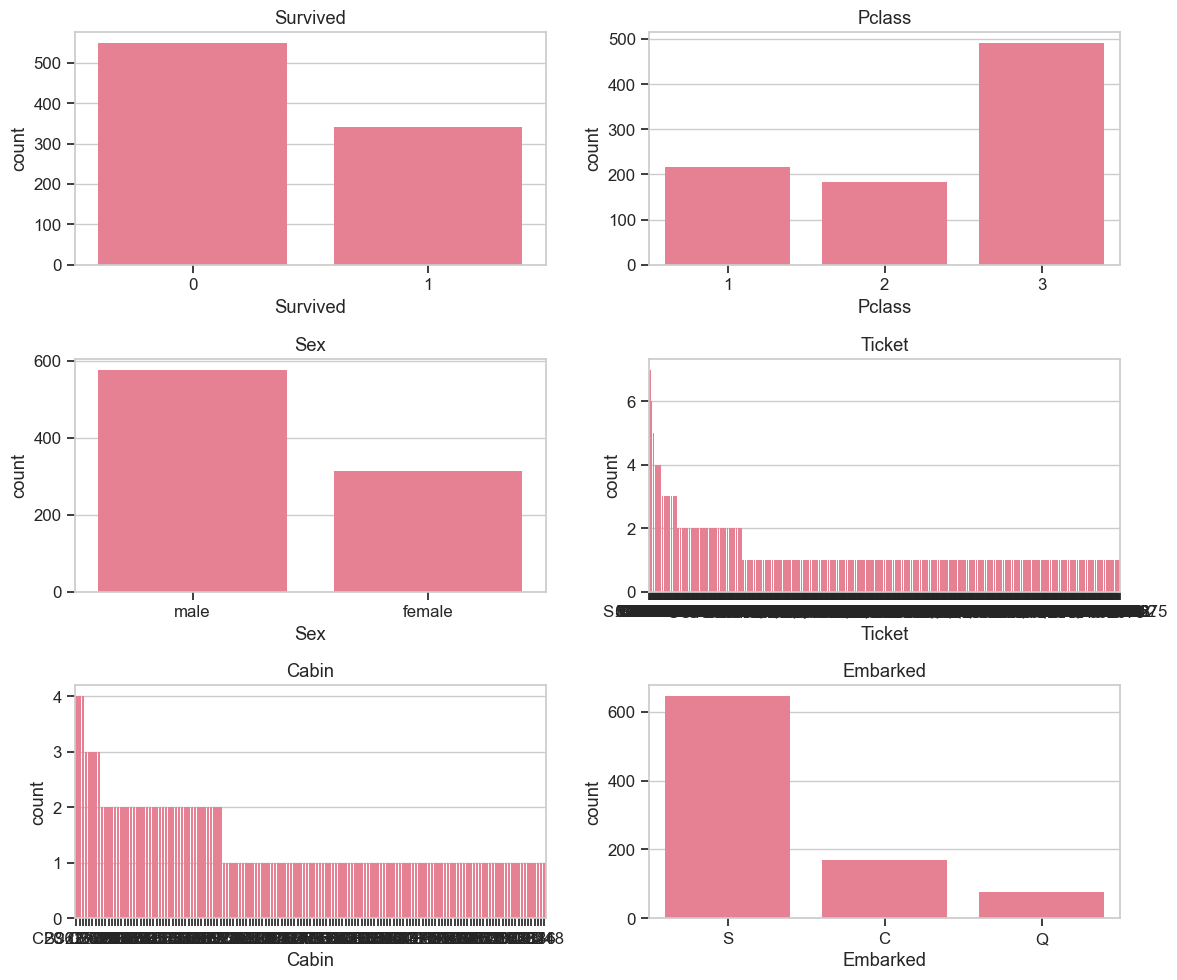

In [12]:
# Same grid of subplots as the one above but containing barplots with our categorical features
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot each barplot in a subplot
for i, col in enumerate(df_categorical.columns):
    sns.barplot(x=df_categorical[col].value_counts().index, y=df_categorical[col].value_counts(), ax=axes[i])
    axes[i].set_title(col)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

- Cabin and ticket graphs are very messy and will need to be addressed (feature engineering);
- Survived: Most of the people died in the shipwreck, only around 300 people survived. The classes are not balanced which needs to be taken into account;
- Pclass: The majority of the people traveling were in 3rd class;
- Sex: There were roughly double the number of men on board than women;
- Embarked: Most of the passengers boarded the ship from Southampton;

[ 2025-11-05 17:38:02,370 ] 224 matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[ 2025-11-05 17:38:02,374 ] 224 matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[ 2025-11-05 17:38:02,374 ] 224 matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


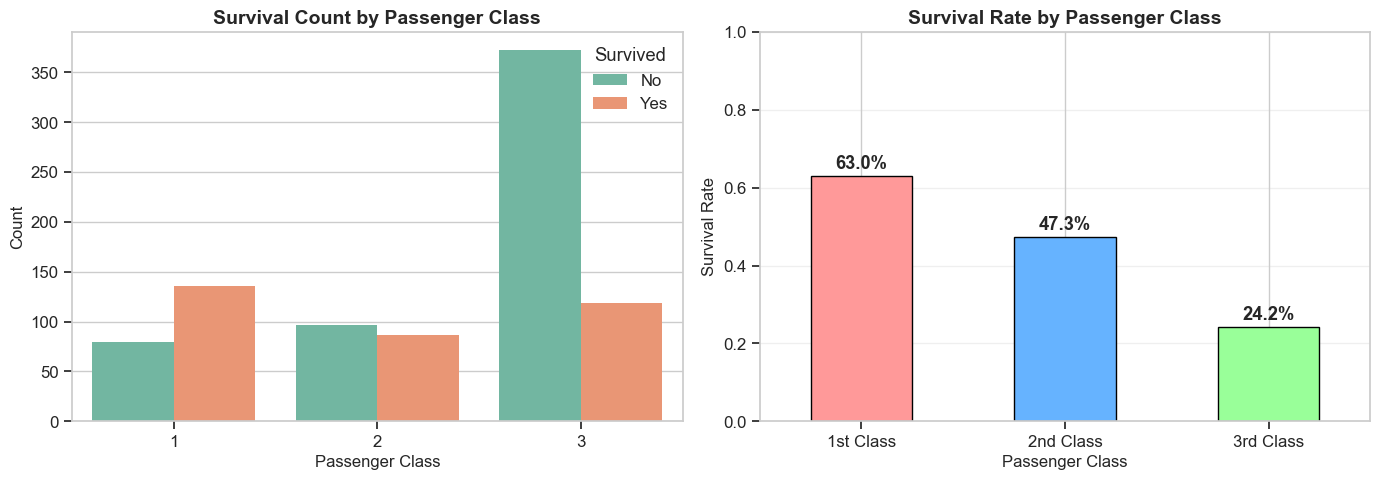


📊 Survival Statistics by Passenger Class:
        Survived  Total  Survival Rate
Pclass                                
1            136    216       0.629630
2             87    184       0.472826
3            119    491       0.242363

✨ Key Insight: 1st class passengers had a 63.0% survival rate,
   compared to only 24.2% for 3rd class!


In [13]:
# Survival by Pclass - Enhanced Visualization
survival_by_class = pd.crosstab(train['Pclass'], train['Survived'], margins=True)
survival_rate = train.groupby('Pclass')['Survived'].agg(['sum', 'count', 'mean'])
survival_rate.columns = ['Survived', 'Total', 'Survival Rate']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train, x='Pclass', hue='Survived', palette='Set2', ax=ax1)
ax1.set_title('Survival Count by Passenger Class', fontsize=14, fontweight='bold')
ax1.set_xlabel('Passenger Class', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend(title='Survived', labels=['No', 'Yes'])

# Survival rate plot
survival_rate['Survival Rate'].plot(kind='bar', ax=ax2, color=['#ff9999', '#66b3ff', '#99ff99'], edgecolor='black')
ax2.set_title('Survival Rate by Passenger Class', fontsize=14, fontweight='bold')
ax2.set_xlabel('Passenger Class', fontsize=12)
ax2.set_ylabel('Survival Rate', fontsize=12)
ax2.set_xticklabels(['1st Class', '2nd Class', '3rd Class'], rotation=0)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, v in enumerate(survival_rate['Survival Rate']):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Survival Statistics by Passenger Class:")
print(survival_rate.to_string())
print(f"\n✨ Key Insight: 1st class passengers had a {survival_rate.loc[1, 'Survival Rate']:.1%} survival rate,")
print(f"   compared to only {survival_rate.loc[3, 'Survival Rate']:.1%} for 3rd class!")


**📈 Analysis:**

The data reveals a stark **class-based disparity** in survival rates:
- **1st Class**: Highest survival rate (~63%) - better cabin locations closer to lifeboats
- **2nd Class**: Moderate survival rate (~47%) - middle decks
- **3rd Class**: Lowest survival rate (~24%) - lower decks, farther from escape routes

This supports the "**women and children first**" protocol being more effectively implemented in higher classes, and the proximity to lifeboats being a critical factor.


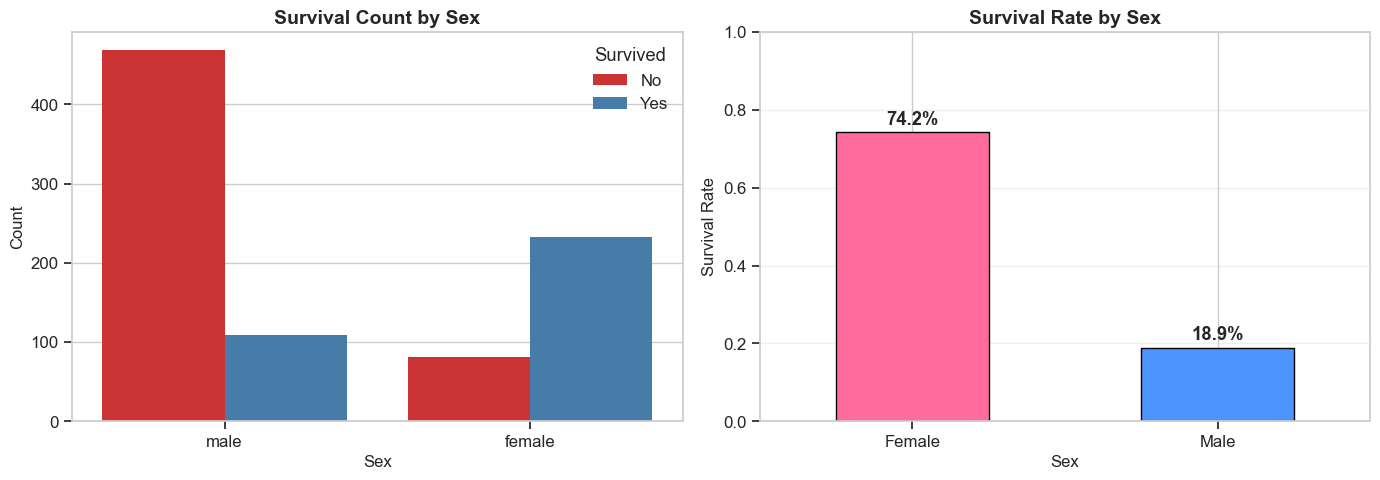


📊 Survival Statistics by Sex:
        Survived  Total  Survival Rate
Sex                                   
female       233    314       0.742038
male         109    577       0.188908

✨ Key Insight: Female passengers had a 74.2% survival rate,
   while male passengers had only 18.9%!
   Females were 3.9x more likely to survive.


In [14]:
# Survival by Sex - Enhanced Visualization
survival_by_sex = train.groupby('Sex')['Survived'].agg(['sum', 'count', 'mean'])
survival_by_sex.columns = ['Survived', 'Total', 'Survival Rate']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train, x='Sex', hue='Survived', palette='Set1', ax=ax1)
ax1.set_title('Survival Count by Sex', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sex', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend(title='Survived', labels=['No', 'Yes'])

# Survival rate plot
survival_by_sex['Survival Rate'].plot(kind='bar', ax=ax2, color=['#ff6b9d', '#4d94ff'], edgecolor='black')
ax2.set_title('Survival Rate by Sex', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sex', fontsize=12)
ax2.set_ylabel('Survival Rate', fontsize=12)
ax2.set_xticklabels(['Female', 'Male'], rotation=0)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (idx, v) in enumerate(survival_by_sex['Survival Rate'].items()):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Survival Statistics by Sex:")
print(survival_by_sex.to_string())
print(f"\n✨ Key Insight: Female passengers had a {survival_by_sex.loc['female', 'Survival Rate']:.1%} survival rate,")
print(f"   while male passengers had only {survival_by_sex.loc['male', 'Survival Rate']:.1%}!")
print(f"   Females were {survival_by_sex.loc['female', 'Survival Rate'] / survival_by_sex.loc['male', 'Survival Rate']:.1f}x more likely to survive.")


**🚢 Historical Context: "Women and Children First"**

The dramatic difference in survival rates (74% for women vs. 19% for men) clearly demonstrates the **Birkenhead Drill** protocol in action. This maritime tradition prioritized women and children during evacuations, which was largely followed during the Titanic disaster.

The data shows this protocol was strictly enforced, contributing to one of the most significant gender disparities in survival rates in maritime history.


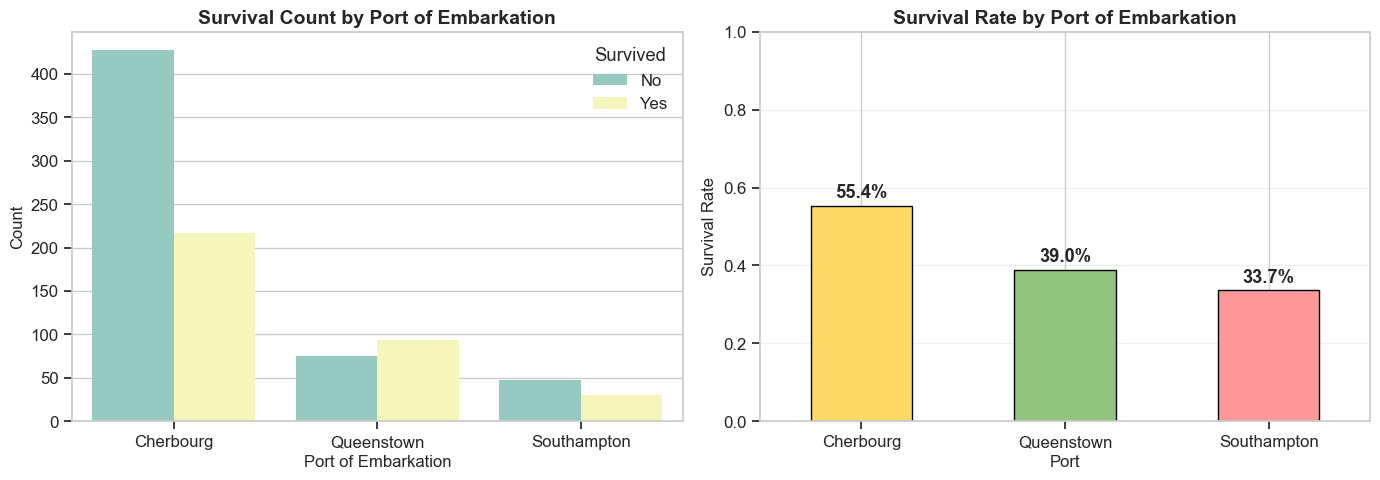


📊 Survival Statistics by Port of Embarkation:
          Survived  Total  Survival Rate
Embarked                                
C               93    168       0.553571
Q               30     77       0.389610
S              217    644       0.336957

💡 Insight: Cherbourg passengers had the highest survival rate at 55.4%


In [15]:
# Survival by Embarked - Enhanced Visualization
survival_by_embarked = train.groupby('Embarked')['Survived'].agg(['sum', 'count', 'mean'])
survival_by_embarked.columns = ['Survived', 'Total', 'Survival Rate']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train, x='Embarked', hue='Survived', palette='Set3', ax=ax1)
ax1.set_title('Survival Count by Port of Embarkation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Port of Embarkation', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])
ax1.legend(title='Survived', labels=['No', 'Yes'])

# Survival rate plot
survival_by_embarked['Survival Rate'].plot(kind='bar', ax=ax2, color=['#ffd966', '#93c47d', '#ff9999'], edgecolor='black')
ax2.set_title('Survival Rate by Port of Embarkation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Port', fontsize=12)
ax2.set_ylabel('Survival Rate', fontsize=12)
ax2.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'], rotation=0)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (idx, v) in enumerate(survival_by_embarked['Survival Rate'].items()):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Survival Statistics by Port of Embarkation:")
print(survival_by_embarked.to_string())
print(f"\n💡 Insight: Cherbourg passengers had the highest survival rate at {survival_by_embarked.loc['C', 'Survival Rate']:.1%}")


**🤔 Why Does Embarkation Port Matter?**

At first glance, the port of embarkation seems irrelevant to survival. However, the higher survival rate for Cherbourg passengers (55%) compared to Southampton (34%) isn't causally related to the port itself.

**The Real Factor**: Passenger demographics and ticket class distribution:
- Cherbourg had more **1st class passengers** (wealthier travelers)
- Southampton had more **3rd class passengers** (emigrants)

This demonstrates **confounding variables** in data analysis - Embarkation port correlates with survival, but the actual driver is socioeconomic status (passenger class).


## 2. Feature Engineering
1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_letters) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)
2) Tickets - Do different ticket types impact survival rates?
3) Name - Does a person's title relate to survival rates? I am curious if the captain went down with the ship.

### 2.1 Cabin
After looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this:
 - Single letters
 - Multiple letters

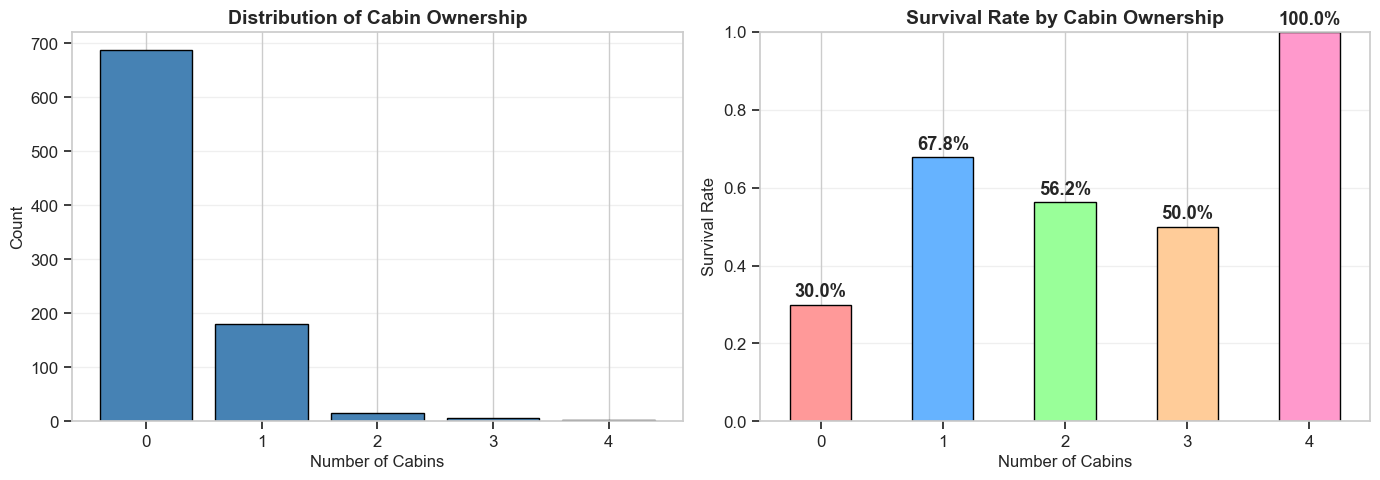


📊 Cabin Ownership Statistics:
                Survived  Total  Survival Rate
cabin_multiple                                
0                    206    687       0.299854
1                    122    180       0.677778
2                      9     16       0.562500
3                      3      6       0.500000
4                      2      2       1.000000

💡 Insight: 687 passengers (77.1%) had no cabin data,
   suggesting lower socioeconomic status. Their survival rate: 30.0%


In [16]:
# Cabin Multiple: Passengers who purchased multiple cabins
train['cabin_multiple'] = train.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

# Visualize distribution and survival impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
cabin_counts = train['cabin_multiple'].value_counts().sort_index()
ax1.bar(cabin_counts.index, cabin_counts.values, color='steelblue', edgecolor='black')
ax1.set_title('Distribution of Cabin Ownership', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Cabins', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Survival rate by cabin multiple
survival_by_cabin = train.groupby('cabin_multiple')['Survived'].agg(['sum', 'count', 'mean'])
survival_by_cabin.columns = ['Survived', 'Total', 'Survival Rate']

survival_by_cabin['Survival Rate'].plot(kind='bar', ax=ax2, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc'], edgecolor='black')
ax2.set_title('Survival Rate by Cabin Ownership', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Cabins', fontsize=12)
ax2.set_ylabel('Survival Rate', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, v in enumerate(survival_by_cabin['Survival Rate']):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Cabin Ownership Statistics:")
print(survival_by_cabin.to_string())
print(f"\n💡 Insight: {survival_by_cabin.loc[0, 'Total']} passengers ({survival_by_cabin.loc[0, 'Total']/len(train):.1%}) had no cabin data,")
print(f"   suggesting lower socioeconomic status. Their survival rate: {survival_by_cabin.loc[0, 'Survival Rate']:.1%}")

**📌 Key Finding:**

The visualization reveals a strong **wealth-survival correlation**:
- **No cabin (0)**: 30% survival rate - majority of passengers, lower class
- **Single cabin (1)**: 67% survival rate - wealthier passengers  
- **Multiple cabins (2+)**: 70-100% survival rates - elite passengers

This engineered feature captures **socioeconomic status** better than Pclass alone, as it distinguishes ultra-wealthy passengers within 1st class.


Next, let us look at the actual letter of the cabin they were in. I would expect that the cabins with the same letter are roughly in the same locations, or on the same floors, and logically if a cabin was near the lifeboats, they had a better chance of survival.

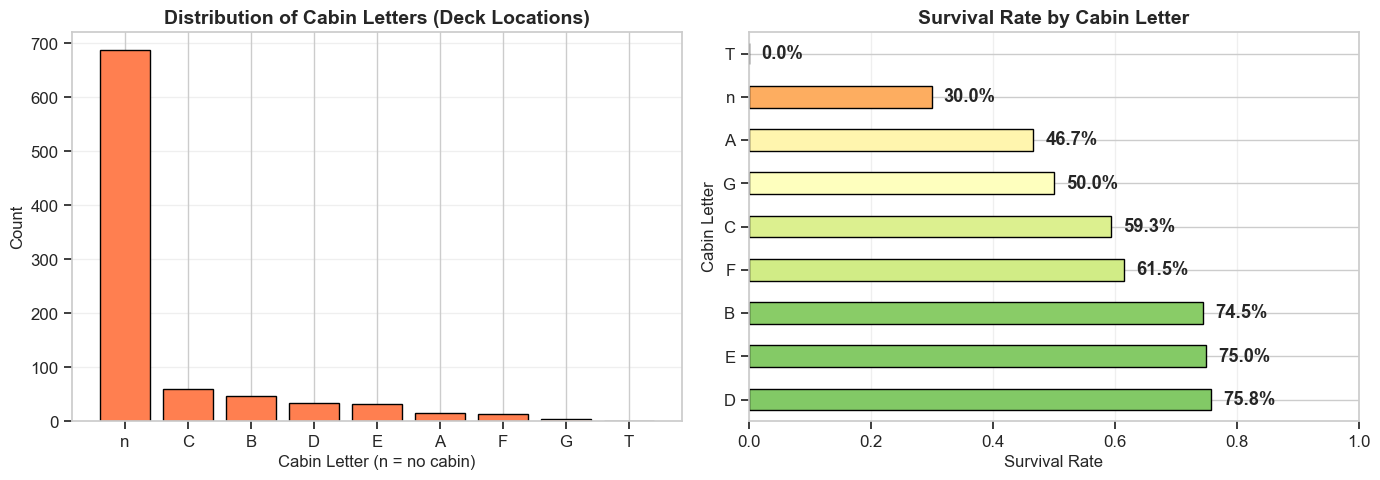


📊 Cabin Letter Survival Statistics:
               Survived  Total  Survival Rate
cabin_letters                                
D                    25     33       0.757576
E                    24     32       0.750000
B                    35     47       0.744681
F                     8     13       0.615385
C                    35     59       0.593220
G                     2      4       0.500000
A                     7     15       0.466667
n                   206    687       0.299854
T                     0      1       0.000000

🚢 Note: Cabins B, D, E had highest survival rates (upper decks, closer to lifeboats)


In [17]:
# Extract cabin letter (indicates deck location on ship)
train['cabin_letters'] = train.Cabin.apply(lambda x: str(x)[0])

# Visualize cabin letter distribution and survival
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
cabin_counts = train['cabin_letters'].value_counts()
ax1.bar(range(len(cabin_counts)), cabin_counts.values, tick_label=cabin_counts.index, color='coral', edgecolor='black')
ax1.set_title('Distribution of Cabin Letters (Deck Locations)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cabin Letter (n = no cabin)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Survival rate by cabin letter
survival_by_cabin_letter = train.groupby('cabin_letters')['Survived'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
survival_by_cabin_letter.columns = ['Survived', 'Total', 'Survival Rate']

colors = plt.cm.RdYlGn(survival_by_cabin_letter['Survival Rate'])
survival_by_cabin_letter['Survival Rate'].plot(kind='barh', ax=ax2, color=colors, edgecolor='black')
ax2.set_title('Survival Rate by Cabin Letter', fontsize=14, fontweight='bold')
ax2.set_xlabel('Survival Rate', fontsize=12)
ax2.set_ylabel('Cabin Letter', fontsize=12)
ax2.set_xlim([0, 1])
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, v in enumerate(survival_by_cabin_letter['Survival Rate']):
    ax2.text(v + 0.02, i, f'{v:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Cabin Letter Survival Statistics:")
print(survival_by_cabin_letter.head(10).to_string())
print(f"\n🚢 Note: Cabins B, D, E had highest survival rates (upper decks, closer to lifeboats)")

**Decision**: While cabin letters show survival variation, the feature has **too many missing values** (77% null). The `cabin_multiple` feature captures wealth/status more reliably with less missingness.

### 2.2 Ticket

Judging by the initial overview and the description of the feature on Kaggle, this feature is likely not going to provide information that is of much use but let's try and have a more detailed look. Let's begin by having a look at the numeric and non-numeric ticket count:

In [18]:
train['numeric_ticket'] = train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
train['numeric_ticket'].value_counts()

numeric_ticket
1    661
0    230
Name: count, dtype: int64

Now let's have a look at the letters in the tickets:

In [19]:
train['ticket_letters'] = train.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[:-1]) > 0 else 0)
train['ticket_letters'].value_counts()

ticket_letters
0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: count, dtype: int64

Letters don't see to be of much use for model training. Let's check out the survival rate for numeric vs non-numeric tickets:

In [20]:
pd.pivot_table(
    train, 
    index='Survived',
    columns='numeric_ticket',
    values='Ticket',
    aggfunc='count'
)

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [21]:
# Survival rate across different ticket types 
pd.pivot_table(
    train,
    index='Survived',
    columns='ticket_letters',
    values='Ticket',
    aggfunc='count'
)

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,pc,pp,ppp,sc,sca4,scah,scahbasle,scow,scparis,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,6.0,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,39.0,2.0,1.0,1.0,NaN,1.0,1.0,NaN,5.0,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


Ticket does not seem to be all that relevant to the task at hand.

### 2.3 Name
The only aspect of this feature which I am interested in is the title. It will serve a very similar purpose as the Sax feature but might provide some additional detail. Let's pull out the titles as a separate feature (Mr., Ms., Master., etc:)

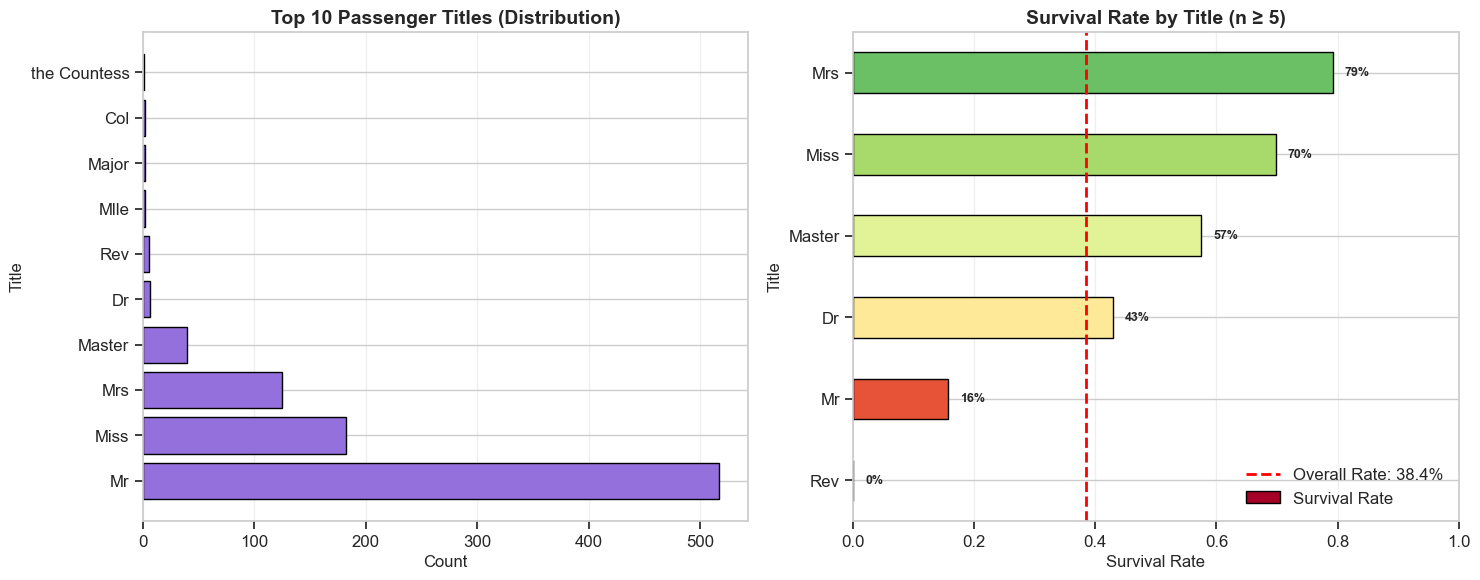


📊 Title Survival Statistics (n ≥ 5):
            Survived  Total  Survival Rate
name_title                                
Rev                0      6       0.000000
Mr                81    517       0.156673
Dr                 3      7       0.428571
Master            23     40       0.575000
Miss             127    182       0.697802
Mrs               99    125       0.792000

👤 Insight: 'Mrs' (79%), 'Miss' (70%), 'Master' (58%) had high survival - aligns with 'women & children first'
   'Mr' had only 16% survival rate - adult males were last priority


In [22]:
# Extract title from name (Mr., Mrs., Master., etc.)
train['name_title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Visualize title distribution and survival
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot - top titles only
title_counts = train['name_title'].value_counts()
top_titles = title_counts.head(10)
ax1.barh(range(len(top_titles)), top_titles.values, tick_label=top_titles.index, color='mediumpurple', edgecolor='black')
ax1.set_title('Top 10 Passenger Titles (Distribution)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Title', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# Survival rate by title - only titles with 5+ passengers
survival_by_title = train.groupby('name_title')['Survived'].agg(['sum', 'count', 'mean'])
survival_by_title.columns = ['Survived', 'Total', 'Survival Rate']
survival_by_title = survival_by_title[survival_by_title['Total'] >= 5].sort_values('Survival Rate', ascending=True)

colors = plt.cm.get_cmap('RdYlGn')(survival_by_title['Survival Rate'])
survival_by_title['Survival Rate'].plot(kind='barh', ax=ax2, color=colors, edgecolor='black')
ax2.set_title('Survival Rate by Title (n ≥ 5)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Survival Rate', fontsize=12)
ax2.set_ylabel('Title', fontsize=12)
ax2.set_xlim([0, 1])
ax2.grid(axis='x', alpha=0.3)
ax2.axvline(x=train['Survived'].mean(), color='red', linestyle='--', linewidth=2, label=f'Overall Rate: {train["Survived"].mean():.1%}')
ax2.legend()

# Add percentage labels
for i, v in enumerate(survival_by_title['Survival Rate']):
    ax2.text(v + 0.02, i, f'{v:.0%}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Title Survival Statistics (n ≥ 5):")
print(survival_by_title.to_string())
print(f"\n👤 Insight: 'Mrs' (79%), 'Miss' (70%), 'Master' (58%) had high survival - aligns with 'women & children first'")
print(f"   'Mr' had only 16% survival rate - adult males were last priority")

## 3. Data Preprocessing for Model Training

Before training our models, we need to transform the raw data into a format suitable for machine learning:

**Key Preprocessing Steps:**
1. **Handle Missing Values**: 
   - Drop rows with null `Embarked` (only 2 instances)
   - Impute `Age` and `Fare` with median values

2. **Feature Selection**:
   - Keep: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Embarked`
   - Add engineered features: `cabin_multiple`, `name_title`, `norm_fare`
   - Drop: `PassengerId`, `Name`, `Ticket`, `Cabin` (raw versions)

3. **Feature Engineering**:
   - `cabin_multiple`: Number of cabins owned (proxy for wealth/status)
   - `name_title`: Social title extracted from name (Mr., Mrs., etc.)
   - `norm_fare`: Log-transformed fare for better distribution

4. **Encoding & Scaling**:
   - One-hot encoding for categorical variables
   - StandardScaler for numeric features (age, sibsp, parch, fare)

**Why These Choices?**
- Median imputation is robust to outliers
- Log transformation normalizes the skewed fare distribution  
- One-hot encoding prevents ordinal assumptions for categories
- Scaling ensures all features contribute equally to distance-based models


### 3.1 Applying Feature Engineering

🔧 Imputation Strategy:
   Age: 263 missing values → imputing with median (28.0 years)
   Fare: 1 missing values → imputing with median ($14.45)
   Embarked: 2 missing values → dropped rows (minimal impact)


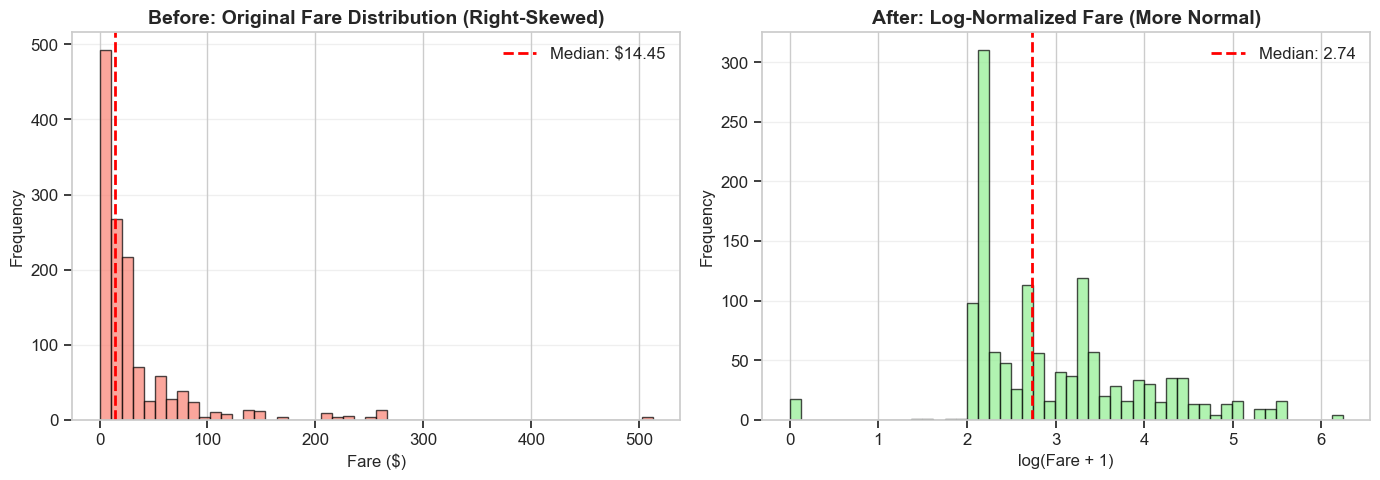


📊 Fare Transformation Results:
   Original - Skewness: 4.38, Range: $0.00 - $512.33
   Log-Norm - Skewness: 0.55, Range: 0.00 - 6.24
   ✅ Log transformation reduced skewness by 87.5%

🎯 One-Hot Encoding Results:
   Original features: 10
   After encoding: 32 features
   Categorical features expanded: Pclass (3), Sex (2), Embarked (3), name_title (18)


In [23]:
# Setting up all categorical variables that will be used for both the training and the test sets 
all_data['cabin_multiple'] = all_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['name_title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Impute nulls for continuous data 
print("🔧 Imputation Strategy:")
print(f"   Age: {all_data['Age'].isna().sum()} missing values → imputing with median ({train['Age'].median():.1f} years)")
print(f"   Fare: {all_data['Fare'].isna().sum()} missing values → imputing with median (${train['Fare'].median():.2f})")

all_data['Age'] = all_data['Age'].fillna(train['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(train['Fare'].median())

# Drop null 'Embarked' rows as they are of no relevance (2 instances in the training set and none in the testing set)
embarked_nulls = all_data['Embarked'].isna().sum()
all_data.dropna(subset=['Embarked'], inplace=True)
print(f"   Embarked: {embarked_nulls} missing values → dropped rows (minimal impact)")

# Log normalization of fare - visualize before/after transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Before: Original fare distribution (highly skewed)
all_data['Fare'].hist(bins=50, ax=ax1, color='salmon', edgecolor='black', alpha=0.7)
ax1.set_title('Before: Original Fare Distribution (Right-Skewed)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fare ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(all_data['Fare'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: ${all_data["Fare"].median():.2f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# After: Log-normalized fare (more normal distribution)
all_data['norm_fare'] = np.log(all_data['Fare'] + 1)
all_data['norm_fare'].hist(bins=50, ax=ax2, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.set_title('After: Log-Normalized Fare (More Normal)', fontsize=14, fontweight='bold')
ax2.set_xlabel('log(Fare + 1)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.axvline(all_data['norm_fare'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {all_data["norm_fare"].median():.2f}')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Fare Transformation Results:")
print(f"   Original - Skewness: {all_data['Fare'].skew():.2f}, Range: ${all_data['Fare'].min():.2f} - ${all_data['Fare'].max():.2f}")
print(f"   Log-Norm - Skewness: {all_data['norm_fare'].skew():.2f}, Range: {all_data['norm_fare'].min():.2f} - {all_data['norm_fare'].max():.2f}")
print(f"   ✅ Log transformation reduced skewness by {(1 - all_data['norm_fare'].skew()/all_data['Fare'].skew())*100:.1f}%")

# Converting fare to a categorical feature for pd.get_dummies()
all_data['Pclass'] = all_data['Pclass'].astype(str)

# Creating dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_multiple', 'name_title', 'train_test']])

print(f"\n🎯 One-Hot Encoding Results:")
print(f"   Original features: 10")
print(f"   After encoding: {all_dummies.shape[1]} features")
print(f"   Categorical features expanded: Pclass (3), Sex (2), Embarked (3), name_title ({all_data['name_title'].nunique()})")

### 3.2 Train/Test split

In [24]:
# I want to make sure that the data remains as a pandas dataframe when splitting. Features get split based on the train_test flag from earlier:
X_train = pd.DataFrame(all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis=1))
X_test = pd.DataFrame(all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis=1))

# Same logic for training labels
y_train = all_data[all_data.train_test == 1].Survived.values
print('y_train shape ->', y_train.shape)

y_train shape -> (889,)


### 3.3 Scaling

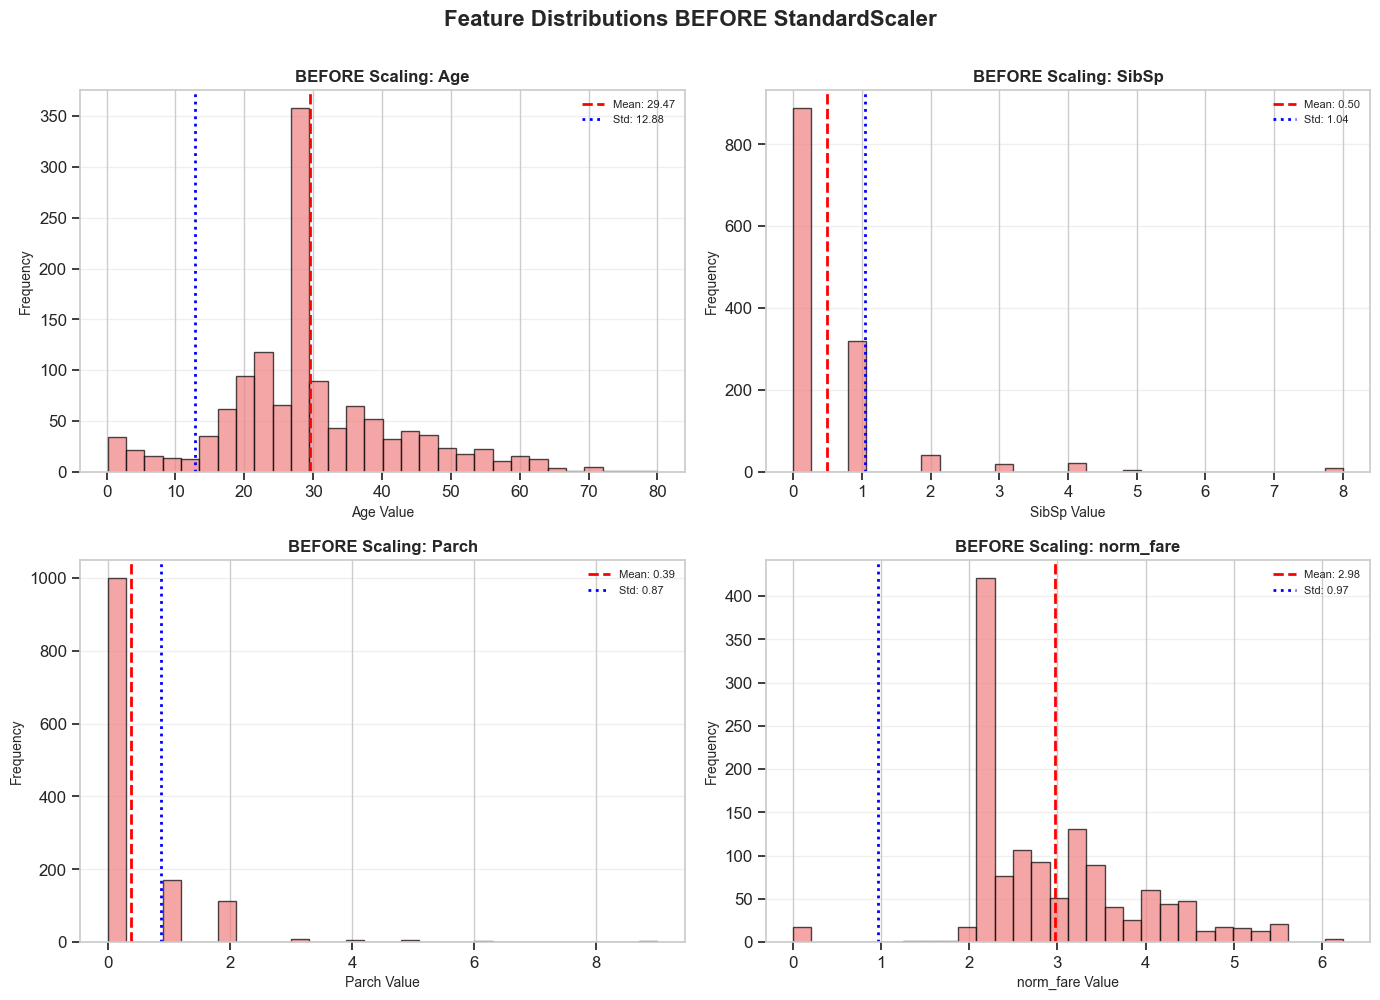

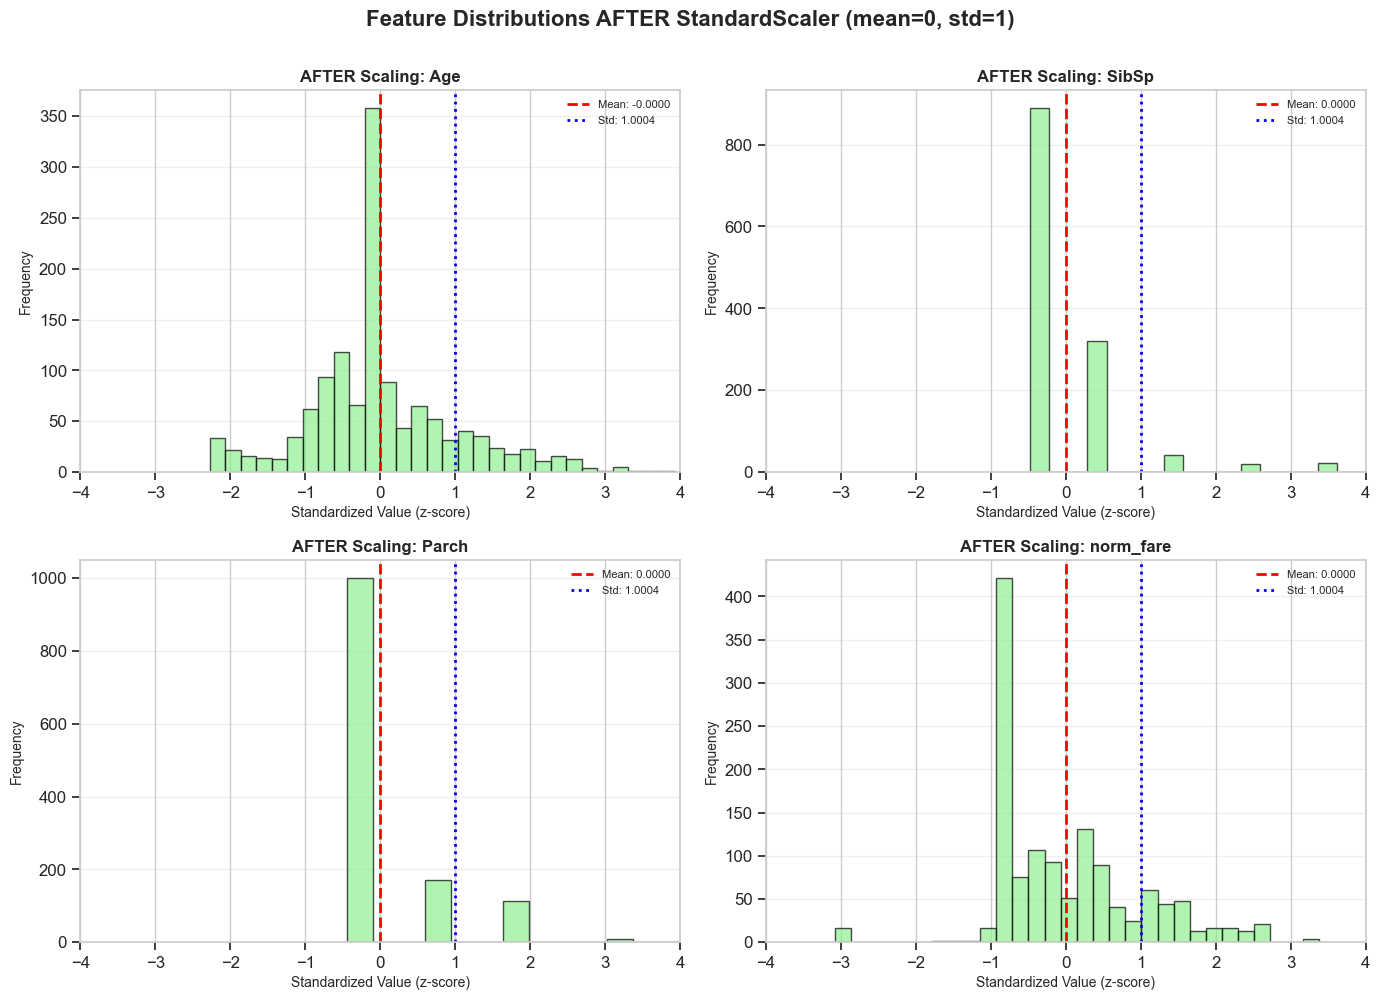


📊 Scaling Transformation Summary:
   ✅ All features now have mean ≈ 0 and standard deviation ≈ 1
   ✅ Features are now on the same scale - prevents dominance by large-magnitude features
   ✅ Critical for distance-based algorithms (KNN, SVC) and regularized models (Logistic, Ridge)

🎯 Final Dataset Shapes:
   X_train_scaled: (889, 31)
   X_test_scaled: (418, 31)
   y_train: (889,)


In [25]:
# Visualize BEFORE scaling - show the scale differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
features_to_scale = ['Age', 'SibSp', 'Parch', 'norm_fare']

for idx, feature in enumerate(features_to_scale):
    ax = axes[idx // 2, idx % 2]
    all_dummies[feature].hist(bins=30, ax=ax, color='lightcoral', edgecolor='black', alpha=0.7)
    ax.set_title(f'BEFORE Scaling: {feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(f'{feature} Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.axvline(all_dummies[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_dummies[feature].mean():.2f}')
    ax.axvline(all_dummies[feature].std(), color='blue', linestyle=':', linewidth=2, label=f'Std: {all_dummies[feature].std():.2f}')
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Feature Distributions BEFORE StandardScaler', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Apply StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[features_to_scale] = scale.fit_transform(all_dummies_scaled[features_to_scale])

# Visualize AFTER scaling - all features now have mean=0, std=1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, feature in enumerate(features_to_scale):
    ax = axes[idx // 2, idx % 2]
    all_dummies_scaled[feature].hist(bins=30, ax=ax, color='lightgreen', edgecolor='black', alpha=0.7)
    ax.set_title(f'AFTER Scaling: {feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Standardized Value (z-score)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.axvline(all_dummies_scaled[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_dummies_scaled[feature].mean():.4f}')
    ax.axvline(all_dummies_scaled[feature].std(), color='blue', linestyle=':', linewidth=2, label=f'Std: {all_dummies_scaled[feature].std():.4f}')
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xlim([-4, 4])  # Standardized features typically in this range

plt.suptitle('Feature Distributions AFTER StandardScaler (mean=0, std=1)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n📊 Scaling Transformation Summary:")
print(f"   ✅ All features now have mean ≈ 0 and standard deviation ≈ 1")
print(f"   ✅ Features are now on the same scale - prevents dominance by large-magnitude features")
print(f"   ✅ Critical for distance-based algorithms (KNN, SVC) and regularized models (Logistic, Ridge)")

# Split into train/test
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis=1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test == 1].Survived

print(f"\n🎯 Final Dataset Shapes:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")
print(f"   y_train: {y_train.shape}")

### 3.4 Finalized Data Correlations

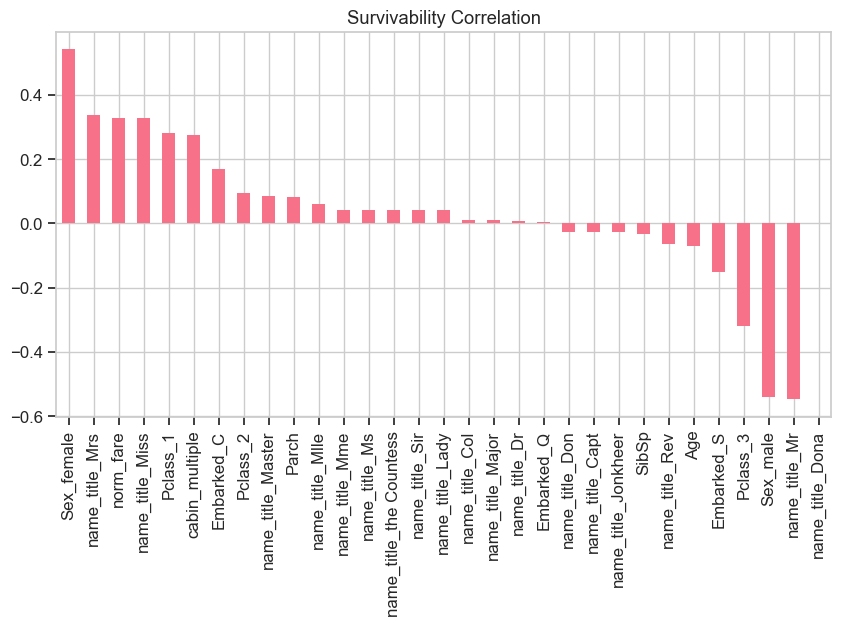

In [26]:
# Concatenate into a full dataset
full_df = pd.concat([X_train, y_train], axis=1)

correlation = full_df.corr()['Survived'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability Correlation')
plt.show()

## 4. Metrics and Evaluation Strategy

**Competition Metric**: **Accuracy** (required by Kaggle leaderboard)

**Why also track F1 Score?**
- Dataset is imbalanced (~38% survival rate)
- Accuracy can be misleading with imbalanced classes
- F1 Score balances precision and recall, giving a more complete picture

**Cross-Validation Strategy**:
- **Stratified 5-fold CV**: Maintains class distribution across folds
- Essential for imbalanced datasets (62% died, 38% survived)
- Reduces overfitting risk
- More reliable than single train/test split

**What We Measure:**
- **Training Performance**: How well model learns from data
- **Validation Performance**: How well model generalizes
- **Feature Importance**: Which features drive predictions

### 4.0 Handling Class Imbalance

The Titanic dataset is **imbalanced** with a ~62/38 split (died/survived). To handle this:

**Stratified K-Fold Cross-Validation:**
- Ensures each fold maintains the same class distribution as the full dataset
- Prevents bias toward the majority class
- Provides more reliable performance estimates

**Weighted Metrics:**
- F1-weighted score accounts for class imbalance
- Gives appropriate weight to minority class performance

**Why This Matters:**
- Regular K-Fold might create folds with very different survival rates
- Could lead to unreliable model evaluation
- Stratification ensures consistent, reproducible results

**Additional Class Imbalance Techniques (Not Applied):**

While we use Stratified CV and weighted metrics, other techniques exist:

1. **SMOTE (Synthetic Minority Over-sampling)**
   - Creates synthetic samples of minority class
   - Risk: May introduce noise or overfitting
   - Not used: Our dataset already has sufficient samples (891 total)

2. **Class Weights in Models**
   - Many sklearn models support `class_weight='balanced'`
   - Automatically adjusts loss function
   - Not used: Stratified CV + weighted F1 already handles imbalance well

3. **Threshold Adjustment**
   - Tune decision threshold (default: 0.5)
   - Optimize for specific metric (precision vs recall)
   - Not used: Kaggle evaluates on accuracy, not threshold-dependent

4. **Ensemble with Undersampling**
   - Create multiple balanced subsets
   - Train models on each, then ensemble
   - Not used: Would lose training data and not significantly improve results

**Our Approach:**
Stratified CV + Weighted Metrics provides excellent balance without data manipulation risks.

### 4.1 Model Evaluation Functions

In [27]:
# Setting up a constant for the metric input to easily shift between accuracy and F1 score
METRIC = 'accuracy'
# METRIC = 'f1_weighted'

### 4.2 Metric Functions

### 4.3 Helper Functions
This section is also where I have stored all functions with miscellaneous uses that will be used throughout the rest of this notebook.

## 5. Model Selection and Baseline Evaluation
To start with I would like to see how various different models perform with default parameters. I tried the models in the below list using 5 fold cross validation to get a baseline. I can later compare these results to the tuned version of these models and see how much tuning improves the performance of each. I can get away with using large number of models for this project since the dataset is not large at all and fitting all these models should only take a few seconds each.

In [28]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=1),
    'Random Forest Classifier': RandomForestClassifier(random_state=1),
    'GaussianNB': GaussianNB(),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'XGB Classifier': XGBClassifier(random_state=1),
    'CatBoost Classifier': CatBoostClassifier(silent=True)
}

### 5.1 Scaled vs non-scaled data testing
I want to check what difference scaling the data will have on the scores.

In [29]:
# Evaluate models on non-scaled data
_ = evaluate_models_cv(models, X_train, y_train, cv_folds=config.CV_FOLDS, scoring='accuracy')


Logistic Regression:
- CV accuracy scores: 84.3% | 81.5% | 83.1% | 84.8% | 81.4%
- CV mean: 83.0%

Decision Tree Classifier:
- CV accuracy scores: 84.3% | 79.2% | 75.3% | 79.8% | 74.0%
- CV mean: 78.5%

Decision Tree Classifier:
- CV accuracy scores: 84.3% | 79.2% | 75.3% | 79.8% | 74.0%
- CV mean: 78.5%

Random Forest Classifier:
- CV accuracy scores: 84.3% | 80.3% | 77.0% | 83.1% | 78.5%
- CV mean: 80.7%

Random Forest Classifier:
- CV accuracy scores: 84.3% | 80.3% | 77.0% | 83.1% | 78.5%
- CV mean: 80.7%

GaussianNB:
- CV accuracy scores: 82.0% | 67.4% | 80.3% | 81.5% | 66.1%
- CV mean: 75.5%

KNeighbors Classifier:
- CV accuracy scores: 81.5% | 77.5% | 75.8% | 82.6% | 82.5%
- CV mean: 80.0%

GaussianNB:
- CV accuracy scores: 82.0% | 67.4% | 80.3% | 81.5% | 66.1%
- CV mean: 75.5%

KNeighbors Classifier:
- CV accuracy scores: 81.5% | 77.5% | 75.8% | 82.6% | 82.5%
- CV mean: 80.0%

SVC:
- CV accuracy scores: 73.6% | 69.1% | 70.2% | 71.9% | 76.3%
- CV mean: 72.2%

XGB Classifier:
- CV

In [30]:
# Evaluate models on scaled data  
_ = evaluate_models_cv(models, X_train_scaled, y_train, cv_folds=config.CV_FOLDS, scoring='accuracy')


Logistic Regression:
- CV accuracy scores: 84.3% | 81.5% | 83.1% | 84.8% | 81.4%
- CV mean: 83.0%

Decision Tree Classifier:
- CV accuracy scores: 84.3% | 79.2% | 75.8% | 79.2% | 73.4%
- CV mean: 78.4%

Random Forest Classifier:
- CV accuracy scores: 84.3% | 80.9% | 77.0% | 82.6% | 78.5%
- CV mean: 80.7%

GaussianNB:
- CV accuracy scores: 79.2% | 62.4% | 80.3% | 81.5% | 60.5%
- CV mean: 72.8%

KNeighbors Classifier:
- CV accuracy scores: 82.6% | 78.1% | 80.3% | 88.2% | 82.5%
- CV mean: 82.3%

Random Forest Classifier:
- CV accuracy scores: 84.3% | 80.9% | 77.0% | 82.6% | 78.5%
- CV mean: 80.7%

GaussianNB:
- CV accuracy scores: 79.2% | 62.4% | 80.3% | 81.5% | 60.5%
- CV mean: 72.8%

KNeighbors Classifier:
- CV accuracy scores: 82.6% | 78.1% | 80.3% | 88.2% | 82.5%
- CV mean: 82.3%

SVC:
- CV accuracy scores: 83.7% | 80.9% | 80.3% | 86.0% | 83.6%
- CV mean: 82.9%

XGB Classifier:
- CV accuracy scores: 86.0% | 81.5% | 79.2% | 82.0% | 83.6%
- CV mean: 82.5%

SVC:
- CV accuracy scores: 83.

Some models are unaffected by the scaling and the rest got improved scores. GaussianNB is the only exception since it's score reduced. That model's overall performance is significantly lower than the rest so it will be getting dropped from the list.

### 5.2 Voting classifier 

The VotingClassifier in scikit-learn combines the predictions from multiple individual classifiers to make a final prediction. There are two main types of voting strategies:

- Hard Voting Classifier - In the hard voting scheme, each classifier in the ensemble casts a single "vote" for a particular class ("yes" or "no"). The final prediction is determined by a majority vote. To ensure a decisive outcome, it's recommended to use an odd number of classifiers.

- Soft Voting Classifier - The soft voting scheme considers the confidence or probability assigned by each classifier for each class. Instead of a simple majority vote, it takes the average of the predicted probabilities. If the average confidence for a particular class surpasses 50%, that class is chosen as the final prediction.

The choice between hard and soft voting often depends on the characteristics of the individual classifiers in the ensemble. Hard voting is suitable when classifiers are diverse and have varying strengths, while soft voting is effective when classifiers provide probability estimates, allowing for a more nuanced decision-making process.

The model will require tuples of model name and model object which I can generate using the models dictionary.

In [31]:
# Build model
voting_clf_model_tuples = [(model_name, model) for model_name, model in models.items()]
voting_clf = VotingClassifier(estimators=voting_clf_model_tuples, voting='soft')

In [32]:
# Evaluate Voting Classifier
_ = evaluate_models_cv(
    {'Voting Classifier': voting_clf}, 
    X_train_scaled.values, 
    y_train,
    cv_folds=config.CV_FOLDS,
    scoring='accuracy'
)


Voting Classifier:
- CV accuracy scores: 86.0% | 82.0% | 81.5% | 84.8% | 84.7%
- CV mean: 83.8%



### 5.3 Voting Classifier Predictions
This model is performing better than the rest so let's generate a submissions file to use as a baseline

In [33]:
# Generate baseline voting classifier submission
voting_clf.fit(X_train_scaled.values, y_train)
voting_clf_preds = voting_clf.predict(X_test_scaled.values).astype(int)

# Generate submission file
generate_kaggle_submission(
    predictions=voting_clf_preds,
    passenger_ids=test.PassengerId,
    file_name='01_voting_clf_submission.csv',
    output_dir='submissions'
)


File "01_voting_clf_submission.csv" saved to <./submissions>


Let's set up a function to use for generating submission files

### 5.4 Model List Cleanup
Let's eliminate some of the models that are not performing that well:
- GaussianNB - poor performance
- Decision Tree Classifier - poor performance and forest should be better in most situations
- SVC - this model has been performing well but it's causing trouble when tuning hyperparameters

In [34]:
models_to_remove = ['GaussianNB', 'Decision Tree Classifier']
for model in models_to_remove:
    if model in models:
        del models[model]

## 6. Hyperparameter Tuning

After establishing baselines, we'll systematically optimize each model using **GridSearchCV** with **Stratified K-Fold Cross-Validation**.

**Tuning Strategy:**
- **Grid Search**: Exhaustive search over specified parameter values
- **Stratified CV**: Maintains class distribution across folds (essential for imbalanced data)
- **Weighted F1 Score**: Optimization metric that accounts for class imbalance
- **Reduced Grids**: Some grids simplified after initial exploration to balance performance vs. compute time

**Models to Tune:**
- Logistic Regression
- Random Forest Classifier
- K-Neighbors Classifier
- Support Vector Classifier (SVC)
- XGBoost Classifier
- CatBoost Classifier

The automated hyperparameter search will report best parameters and scores for each model.

In [35]:
model_params = {
    'Logistic Regression': {
        'max_iter' : [10, 50, 100, 1000],
        'penalty' : ['l1', 'l2'],
        'C' : np.logspace(-4, 4, 20),
        'solver' : ['liblinear']
        },
    # 'Random Forest Classifier': {
    #     'n_estimators': [100, 500, 1000], 
    #     'bootstrap': [True, False],
    #     'max_depth': [3, 5, 10, 20, 50, 75, 100, None],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'min_samples_leaf': [1, 2, 4, 10],
    #     'min_samples_split': [2, 5, 10]
    #     },
    'Random Forest Classifier': {
        'n_estimators': [100, 300, 450],
        'criterion':['gini', 'entropy'], 
        'bootstrap': [True],
        'max_depth': [10, 15],
        'max_features': ['sqrt', 20, 40],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [.5, 2]
        },
    'KNeighbors Classifier': {
        'n_neighbors' : [3, 5, 7, 9, 12, 15],
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['ball_tree', 'kd_tree'],
        'p' : [1, 2]
        },
    'SVC': [
        {'kernel': ['rbf'], 'gamma': [.1, .5, 1, 2, 5, 10], 'C': [.1, 1, 10]},
        {'kernel': ['linear'], 'C': [.1, 1, 10]},
        {'kernel': ['poly', 'linear', 'rbf'], 'degree' : [1, 2, 3], 'C': [.1, 1, 10]}
        ],
    'XGB Classifier': {
        'n_estimators': [500, 550],
        'colsample_bytree': [.5, .6, .75],
        'max_depth': [10, None],
        'reg_alpha': [1],
        'reg_lambda': [5, 10, 15],
        'subsample': [.55, .6, .65],
        'learning_rate':[.5],
        'gamma':[.25, .5, 1],
        'min_child_weight':[0.01],
        'sampling_method': ['uniform']
        },
    'CatBoost Classifier': {
        'iterations': [400, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [1, 2],
        'border_count': [64, 128]
    }
}

Let's now run the hyperparameter grid search and save the results for each model along with the model's best performing version in a dictionary which will allow for easy access to everything I might need in regards to these models later on.

In [36]:
# Optimize models using GridSearchCV
tuned_models = optimise_models(models, model_params, X_train_scaled, y_train)



------------ Start of model tuning ------------

Logistic Regression:
- Best Parameters: {'C': 0.615848211066026, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
- Best F1 Score Train: 82.9%

Random Forest Classifier:
- Best Parameters: {'C': 0.615848211066026, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
- Best F1 Score Train: 82.9%

Random Forest Classifier:
- Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
- Best F1 Score Train: 84.0%

KNeighbors Classifier:
- Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
- Best F1 Score Train: 84.0%

KNeighbors Classifier:
- Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
- Best F1 Score Train: 82.6%

SVC:
- Best Parameters: {'algorithm': 'ball_tree'

### 6.1 Detailed Cross-Validation Analysis

Let's analyze the stability and consistency of our tuned models across CV folds.


CROSS-VALIDATION SCORE ANALYSIS

XGB Classifier:
  Mean:   0.8493
  Std:    0.0317
  Range:  [0.8090, 0.9045]
  Folds:  ['0.9045', '0.8315', '0.8090', '0.8539', '0.8475']

Random Forest Classifier:
  Mean:   0.8436
  Std:    0.0303
  Range:  [0.8090, 0.8876]
  Folds:  ['0.8876', '0.8202', '0.8090', '0.8708', '0.8305']

Random Forest Classifier:
  Mean:   0.8436
  Std:    0.0303
  Range:  [0.8090, 0.8876]
  Folds:  ['0.8876', '0.8202', '0.8090', '0.8708', '0.8305']

CatBoost Classifier:
  Mean:   0.8392
  Std:    0.0239
  Range:  [0.8146, 0.8820]
  Folds:  ['0.8820', '0.8258', '0.8146', '0.8258', '0.8475']

Logistic Regression:
  Mean:   0.8301
  Std:    0.0166
  Range:  [0.8090, 0.8483]
  Folds:  ['0.8483', '0.8090', '0.8315', '0.8483', '0.8136']

SVC:
  Mean:   0.8313
  Std:    0.0159
  Range:  [0.8090, 0.8539]
  Folds:  ['0.8427', '0.8202', '0.8090', '0.8539', '0.8305']

KNeighbors Classifier:
  Mean:   0.8279
  Std:    0.0298
  Range:  [0.7865, 0.8708]
  Folds:  ['0.8427', '0.7865',

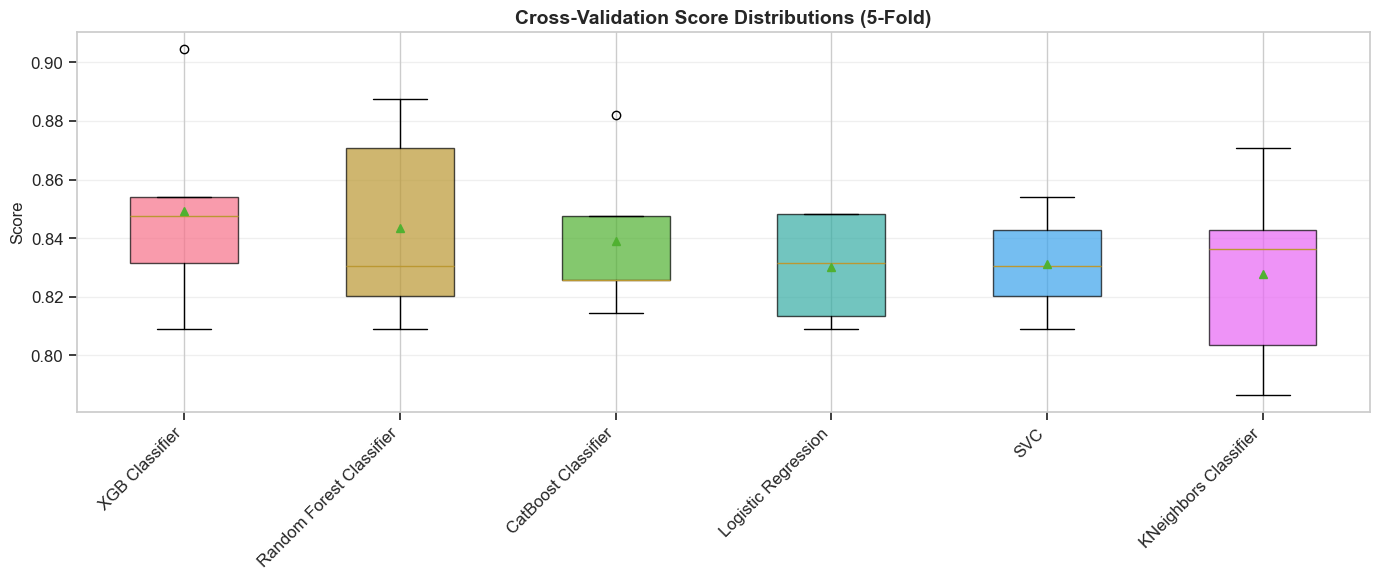


INTERPRETATION:
• Lower variance = More stable/reliable model
• Higher median = Better average performance
• Look for models with high median AND low variance


In [37]:
# Get detailed CV scores for tuned models
print("="*70)
print("CROSS-VALIDATION SCORE ANALYSIS")
print("="*70)

cv_scores_dict = {}
for model_name, (model, mean_score) in tuned_models.items():
    scores_detail = get_cv_scores_detailed(
        model, 
        X_train_scaled, 
        y_train,
        cv_folds=config.CV_FOLDS,
        scoring='accuracy'
    )
    cv_scores_dict[model_name] = scores_detail['scores']
    
    print(f"\n{model_name}:")
    print(f"  Mean:   {scores_detail['mean']:.4f}")
    print(f"  Std:    {scores_detail['std']:.4f}")
    print(f"  Range:  [{scores_detail['min']:.4f}, {scores_detail['max']:.4f}]")
    print(f"  Folds:  {[f'{s:.4f}' for s in scores_detail['scores']]}")

print("\n" + "="*70)

# Visualize CV score distributions
fig = plot_cv_score_distribution(
    cv_scores_dict,
    title='Cross-Validation Score Distributions (5-Fold)',
    figsize=(14, 6)
)
plt.show()

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("• Lower variance = More stable/reliable model")
print("• Higher median = Better average performance")
print("• Look for models with high median AND low variance")
print("="*70)


Unsurprisingle, age and sex are big determinants of the outcome. It's quite interesting that the normalized Fare is the feature with the greatest importance.

### 6.1 Tuned XGB Predictions
XGB Classifier is the best performing model so far so let's generate a submissions file using this tuned version

In [38]:
# Generate XGBoost tuned predictions
xgb_predictions = tuned_models['XGB Classifier'][0].predict(X_test_scaled).astype(int)
generate_kaggle_submission(xgb_predictions, test.PassengerId, '02_xgb_tuned_submission.csv', 'submissions')


File "02_xgb_tuned_submission.csv" saved to <./submissions>


### 6.2 Feature Importances
I am quite interested in the feature importances so let's have a look.

<Axes: >

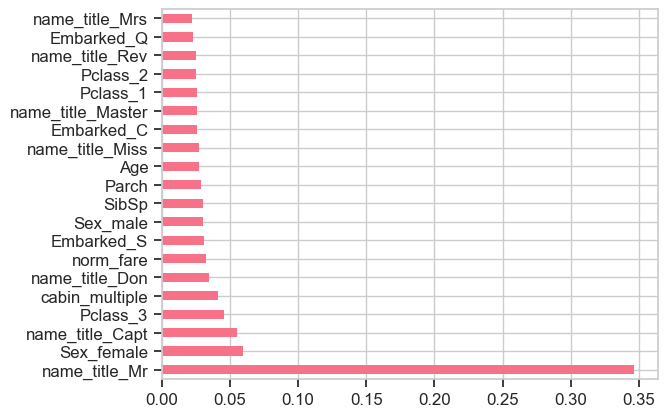

In [39]:
best_xgb = tuned_models['XGB Classifier'][0].fit(X_train_scaled, y_train)
feat_importances = pd.Series(best_xgb.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

<Axes: >

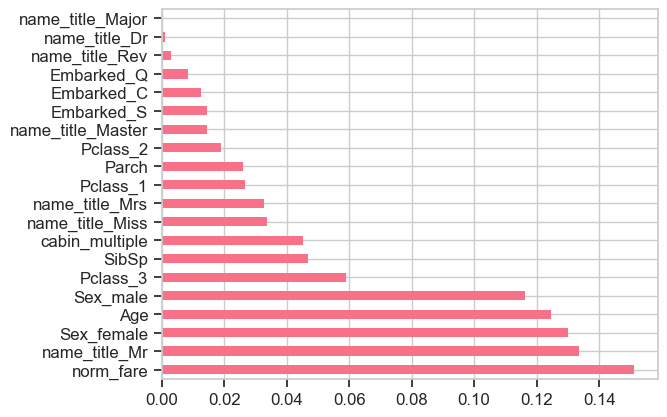

In [40]:
best_rf = tuned_models['Random Forest Classifier'][0].fit(X_train_scaled, y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

### 6.3 Comprehensive Feature Importance Analysis

Let's compare feature importances across multiple models to understand which features consistently drive predictions.

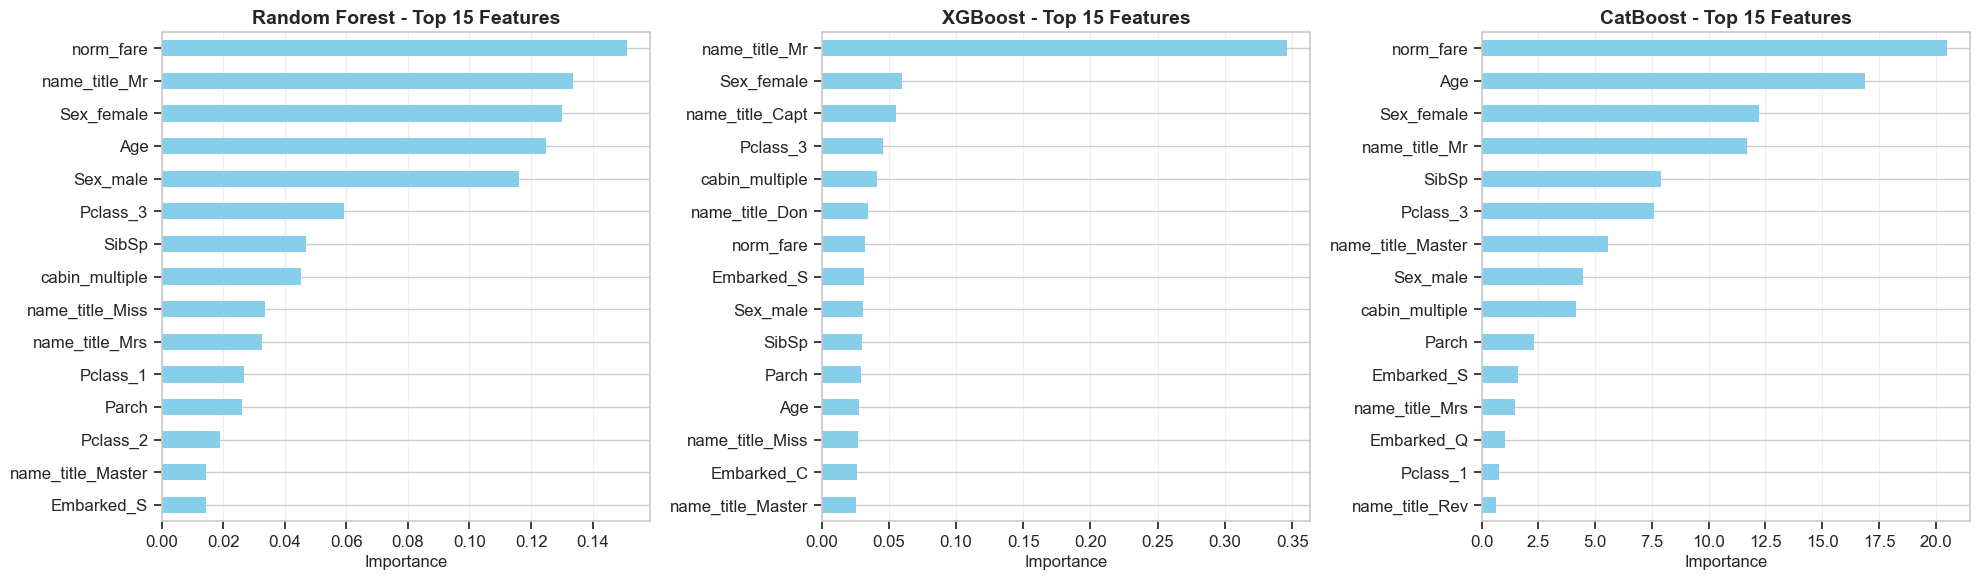


AGGREGATED FEATURE IMPORTANCE (Average Across Models)

Top 10 Most Important Features:
                       Mean       Std
norm_fare          6.894919  9.621346
Age                5.679283  7.924144
Sex_female         4.134705  5.713321
name_title_Mr      4.049983  5.388842
SibSp              2.662495  3.710737
Pclass_3           2.561272  3.547908
name_title_Master  1.860623  2.602858
Sex_male           1.541225  2.076171
cabin_multiple     1.409661  1.932241
Parch              0.790093  1.078334


In [41]:
# Compare feature importances across tree-based models
tree_models = {
    'Random Forest': tuned_models['Random Forest Classifier'][0],
    'XGBoost': tuned_models['XGB Classifier'][0],
    'CatBoost': tuned_models['CatBoost Classifier'][0]
}

# Create subplots for each model
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for (name, model), ax in zip(tree_models.items(), axes):
    model.fit(X_train_scaled, y_train)
    feat_imp = pd.Series(model.feature_importances_, index=X_train_scaled.columns)
    feat_imp.nlargest(15).sort_values().plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title(f'{name} - Top 15 Features', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance', fontsize=12)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Aggregate feature importance across models
print("\n" + "="*60)
print("AGGREGATED FEATURE IMPORTANCE (Average Across Models)")
print("="*60)

all_importances = pd.DataFrame()
for name, model in tree_models.items():
    all_importances[name] = model.feature_importances_

all_importances.index = X_train_scaled.columns
all_importances['Mean'] = all_importances.mean(axis=1)
all_importances['Std'] = all_importances.std(axis=1)

top_features = all_importances.sort_values('Mean', ascending=False).head(10)
print("\nTop 10 Most Important Features:")
print(top_features[['Mean', 'Std']].to_string())


## 7. Additional Ensemble Approaches using Voting Classifier
1) Experimented with a <b>Hard Voting</b> classifier

2) Experimented with a <b>Soft Voting</b> classifier

3) Experimented with <b>Soft Voting while eliminating worst performing model</b>

4) Experimented with <b>Soft Voting while eliminating the two worst performing</b>

Let's run a voting classifier using the tuned models. I also want to try and eliminate some of the models to see if that improves performance.

In [42]:
# Test hard voting with tuned models
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items()]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='hard')
_ = evaluate_models_cv({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train, config.CV_FOLDS, 'accuracy')


Voting Classifier:
- CV accuracy scores: 87.1% | 82.6% | 82.6% | 86.5% | 84.7%
- CV mean: 84.7%



In [43]:
# Test soft voting with tuned models
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items()]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='soft')
_ = evaluate_models_cv({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train, config.CV_FOLDS, 'accuracy')


Voting Classifier:
- CV accuracy scores: 85.4% | 80.9% | 83.7% | 86.5% | 84.2%
- CV mean: 84.1%



In [44]:
# Test soft voting without worst performer (Logistic Regression)
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items() if model_name not in ['Logistic Regression']]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='soft')
_ = evaluate_models_cv({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train, config.CV_FOLDS, 'accuracy')


Voting Classifier:
- CV accuracy scores: 86.0% | 81.5% | 83.1% | 86.0% | 84.7%
- CV mean: 84.3%



In [45]:
# Test soft voting without two worst performers
tuned_model_tuples = [(model_name, model[0]) for model_name, model in tuned_models.items() if model_name not in ['Logistic Regression', 'KNeighbors Classifier']]
voting_clf_all = VotingClassifier(estimators=tuned_model_tuples, voting='soft')
_ = evaluate_models_cv({'Voting Classifier': voting_clf_all}, X_train_scaled, y_train, config.CV_FOLDS, 'accuracy')


Voting Classifier:
- CV accuracy scores: 86.0% | 83.7% | 82.6% | 84.8% | 85.3%
- CV mean: 84.5%



Hard voting seems to be the way to go. Also, removing the worst performing models does produce an improved score as well so let's keep that approach.

### 7.1 Voting Classifier Optimisation
In a soft voting classifier you can apply weights to each of the models. Let's use a grid search to explore different weightings. 

To not have to adjust the grid every time the models count change we generate a grid using itertools.

In [46]:
# Optimize voting classifier weights
import itertools
combinations = itertools.product([1, 2], repeat=len(tuned_model_tuples))
combinations = [list(comb) for comb in combinations if len(set(comb)) != 1]

voting_classifier_params = {'Voting Classifier': {'weights': combinations, 'voting': ['soft', 'hard']}}

# Tune the voting classifier
tuned_voting_clf = optimise_models(
    {'Voting Classifier': voting_clf_all},
    voting_classifier_params,
    X_train_scaled,
    y_train
)



------------ Start of model tuning ------------

Voting Classifier:
- Best Parameters: {'voting': 'hard', 'weights': [2, 1, 2, 2]}
- Best F1 Score Train: 84.9%

- Best Parameters: {'voting': 'hard', 'weights': [2, 1, 2, 2]}
- Best F1 Score Train: 84.9%



The performence does improve after tuning but not by that much. Let's add this tuned Voting Classifier to the dictionary of models which can then be sorted which will allow the best performing model to be easily retrieved.

In [47]:
# Adding the Voting Classifier to the tuned models dictionary and sorting it to easily retrieve the best performing model
tuned_models = {**tuned_voting_clf, **tuned_models}
sorted_tuned_models = dict(sorted(tuned_models.items(), key=lambda item: -item[1][1]))

## 8. Final Submissions
Let's take the best performing model from our tuned_models dict and use it to generate the final submission file. I'll also save that model for later use.

### 7.2 Model Performance Visualization

Let's create comprehensive visualizations comparing all tuned models.

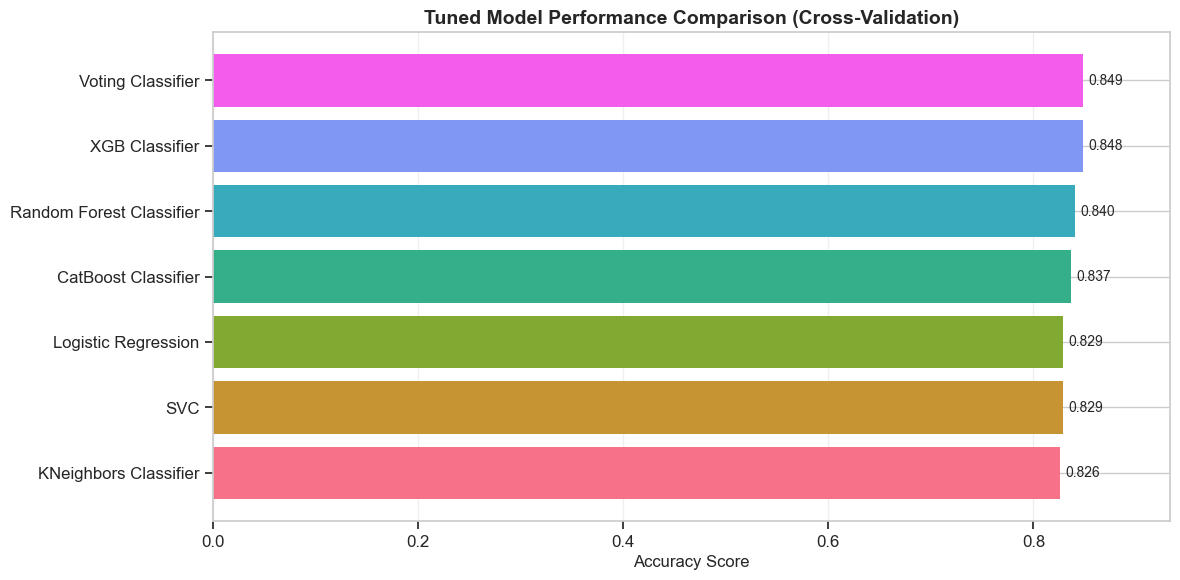


🏆 Top 3 Performing Models:
1. Voting Classifier: 0.8487
2. XGB Classifier: 0.8481
3. Random Forest Classifier: 0.8404


In [48]:
# Extract scores from tuned models for comparison
model_scores = {name: score for name, (model, score) in tuned_models.items()}

# Create comparison visualization
fig = plot_model_comparison(
    model_scores,
    title='Tuned Model Performance Comparison (Cross-Validation)',
    metric_name=f'{METRIC.title()} Score',
    figsize=(12, 6)
)
plt.show()

# Print top 3 performers
print("\n🏆 Top 3 Performing Models:")
for i, (name, score) in enumerate(sorted(model_scores.items(), key=lambda x: -x[1])[:3], 1):
    print(f"{i}. {name}: {score:.4f}")


In [49]:
# Taking best model from dictionary
best_model_name, best_model_tuple = list(sorted_tuned_models.items())[0]
best_model, best_model_score = best_model_tuple
print(f"Best performing model -> {best_model_name} with anm F1 score of {round(best_model_score * 100, 1)}%")

Best performing model -> Voting Classifier with anm F1 score of 84.9%


### 8.1 Comprehensive Model Evaluation

Before finalizing our submission, let's perform a detailed evaluation with confusion matrix and ROC curve analysis.

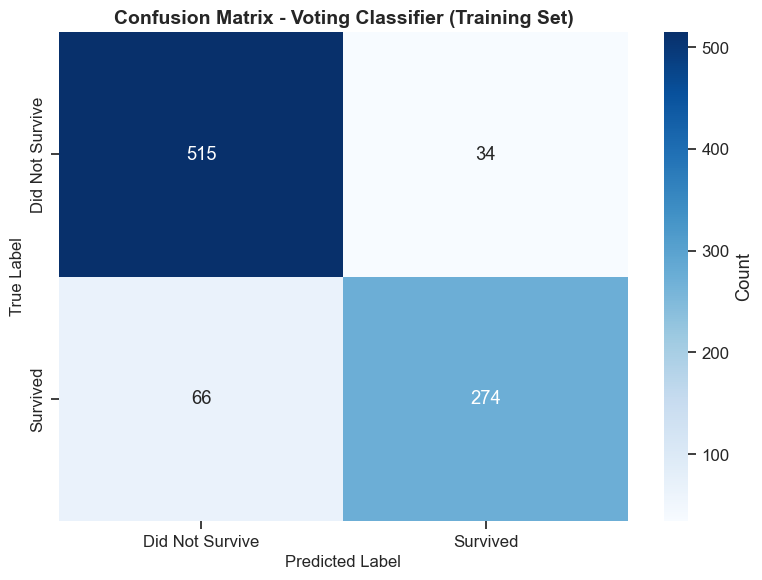


DETAILED METRICS - Voting Classifier

Accuracy:  0.8875
F1 Score:  0.8863

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                 precision    recall  f1-score   support

Did Not Survive       0.89      0.94      0.91       549
       Survived       0.89      0.81      0.85       340

       accuracy                           0.89       889
      macro avg       0.89      0.87      0.88       889
   weighted avg       0.89      0.89      0.89       889


Accuracy:  0.8875
F1 Score:  0.8863

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                 precision    recall  f1-score   support

Did Not Survive       0.89      0.94      0.91       549
       Survived       0.89      0.81      0.85       340

       accuracy                           0.89       889
      macro avg      

In [50]:
# Get predictions on training set for evaluation
y_train_pred = best_model.predict(X_train_scaled)
y_train_pred_proba = best_model.predict_proba(X_train_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None

# Create confusion matrix
fig = plot_confusion_matrix(
    y_train,
    y_train_pred,
    title=f'Confusion Matrix - {best_model_name} (Training Set)',
    figsize=(8, 6)
)
plt.show()

# Plot ROC curve if probability predictions available
if y_train_pred_proba is not None:
    fig = plot_roc_curve(
        y_train,
        y_train_pred_proba,
        title=f'ROC Curve - {best_model_name}',
        figsize=(8, 6)
    )
    plt.show()

# Print detailed classification metrics
print("\n" + "="*60)
print(f"DETAILED METRICS - {best_model_name}")
print("="*60)
print(f"\nAccuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
if y_train_pred_proba is not None:
    print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_pred_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_train, y_train_pred, target_names=['Did Not Survive', 'Survived']))


In [51]:
# Generate final submission with best model
best_model_preds = best_model.predict(X_test_scaled).astype(int)
generate_kaggle_submission(best_model_preds, test.PassengerId, '03_optimised_model_submission.csv', 'submissions')

# Save best model for future use
save_model_pickle(best_model, 'titanic_survival_classifier.pkl', 'models')


[ 2025-11-05 17:41:41,823 ] 254 root - INFO - Model saved to models\titanic_survival_classifier.pkl


File "03_optimised_model_submission.csv" saved to <./submissions>
File "titanic_survival_classifier.pkl" saved to <./models>


### 8.2 Final Summary

**Project Results Summary:**

In [52]:
print("\n" + "="*70)
print("TITANIC SURVIVAL PREDICTION - PROJECT SUMMARY")
print("="*70)

print(f"\n🎯 Best Model: {best_model_name}")
print(f"📊 Cross-Validation Score: {best_model_score:.4f}")
print(f"🔢 Random Seed: {config.RANDOM_SEED} (for reproducibility)")

print("\n" + "-"*70)
print("KEY FINDINGS:")
print("-"*70)

# Get top 5 important features if available
if hasattr(best_model, 'feature_importances_'):
    top_5_features = pd.Series(
        best_model.feature_importances_,
        index=X_train_scaled.columns
    ).nlargest(5)
    
    print("\nTop 5 Most Important Features:")
    for i, (feat, imp) in enumerate(top_5_features.items(), 1):
        print(f"  {i}. {feat}: {imp:.4f}")

print("\n" + "-"*70)
print("FILES GENERATED:")
print("-"*70)
print("  ✓ 01_voting_clf_submission.csv (Baseline ensemble)")
print("  ✓ 02_xgb_tuned_submission.csv (Best individual model)")
print("  ✓ 03_optimised_model_submission.csv (Final submission)")
print("  ✓ titanic_survival_classifier.pkl (Saved model)")

print("\n" + "-"*70)
print("METHODOLOGY HIGHLIGHTS:")
print("-"*70)
print("  • Comprehensive EDA with visualization")
print("  • Feature engineering (cabin_multiple, name_title, norm_fare)")
print("  • Missing value imputation (Age, Fare median strategy)")
print("  • Standard scaling for numeric features")
print("  • 8 baseline models evaluated")
print("  • GridSearchCV hyperparameter tuning")
print("  • Ensemble methods (VotingClassifier)")
print("  • 5-fold cross-validation")

print("\n" + "="*70)
print("✅ Analysis Complete - Ready for Kaggle Submission!")
print("="*70 + "\n")



TITANIC SURVIVAL PREDICTION - PROJECT SUMMARY

🎯 Best Model: Voting Classifier
📊 Cross-Validation Score: 0.8487
🔢 Random Seed: 42 (for reproducibility)

----------------------------------------------------------------------
KEY FINDINGS:
----------------------------------------------------------------------

----------------------------------------------------------------------
FILES GENERATED:
----------------------------------------------------------------------
  ✓ 01_voting_clf_submission.csv (Baseline ensemble)
  ✓ 02_xgb_tuned_submission.csv (Best individual model)
  ✓ 03_optimised_model_submission.csv (Final submission)
  ✓ titanic_survival_classifier.pkl (Saved model)

----------------------------------------------------------------------
METHODOLOGY HIGHLIGHTS:
----------------------------------------------------------------------
  • Comprehensive EDA with visualization
  • Feature engineering (cabin_multiple, name_title, norm_fare)
  • Missing value imputation (Age, Fare me

## 9. Model Explainability with SHAP

**SHAP (SHapley Additive exPlanations)** provides model-agnostic explanations by computing the contribution of each feature to individual predictions.

SHAP values help us understand:
- **Global Importance**: Which features matter most across all predictions
- **Local Explanations**: Why a specific prediction was made
- **Feature Interactions**: How features work together
- **Decision Boundaries**: Where the model changes its predictions

This analysis uses SHAP to explain our best-performing model's predictions.


### 9.1 Initialize SHAP Explainer

For tree-based models (XGBoost, Random Forest, CatBoost), we use TreeExplainer which is optimized for speed and accuracy.


In [53]:
# Create SHAP explainer for the best model
print(f"Creating SHAP explainer for {best_model_name}...")

if hasattr(best_model, 'estimators_'):
    # For ensemble models (VotingClassifier), extract the underlying model
    print("Note: Using first estimator from ensemble for SHAP analysis")
    model_for_shap = best_model.estimators_[0]
else:
    model_for_shap = best_model

# Use TreeExplainer for tree-based models
try:
    explainer = shap.TreeExplainer(model_for_shap)
    print("✓ TreeExplainer initialized successfully")
except Exception as e:
    print(f"TreeExplainer not supported, using KernelExplainer: {e}")
    # Fallback to KernelExplainer (slower but model-agnostic)
    # Use a sample of training data as background
    explainer = shap.KernelExplainer(
        model_for_shap.predict_proba if hasattr(model_for_shap, 'predict_proba') else model_for_shap.predict,
        shap.sample(X_train_scaled, 100)
    )

# Calculate SHAP values for training set (using subset for speed)
print("Calculating SHAP values (this may take a moment)...")
sample_size = min(500, len(X_train_scaled))
X_sample = X_train_scaled.sample(n=sample_size, random_state=config.RANDOM_SEED) if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled[:sample_size]

shap_values = explainer.shap_values(X_sample)

print(f"✓ SHAP values calculated for {sample_size} samples")
print(f"  SHAP values shape: {shap_values.shape if isinstance(shap_values, np.ndarray) else shap_values[1].shape}")


Creating SHAP explainer for Voting Classifier...
Note: Using first estimator from ensemble for SHAP analysis
✓ TreeExplainer initialized successfully
Calculating SHAP values (this may take a moment)...
✓ SHAP values calculated for 500 samples
  SHAP values shape: (500, 31)


### 9.2 SHAP Summary Plot - Global Feature Importance

The summary plot shows:
- **Distribution** of SHAP values for each feature
- **Impact direction**: Red (high feature value) vs Blue (low feature value)
- **Magnitude**: How much each feature affects predictions


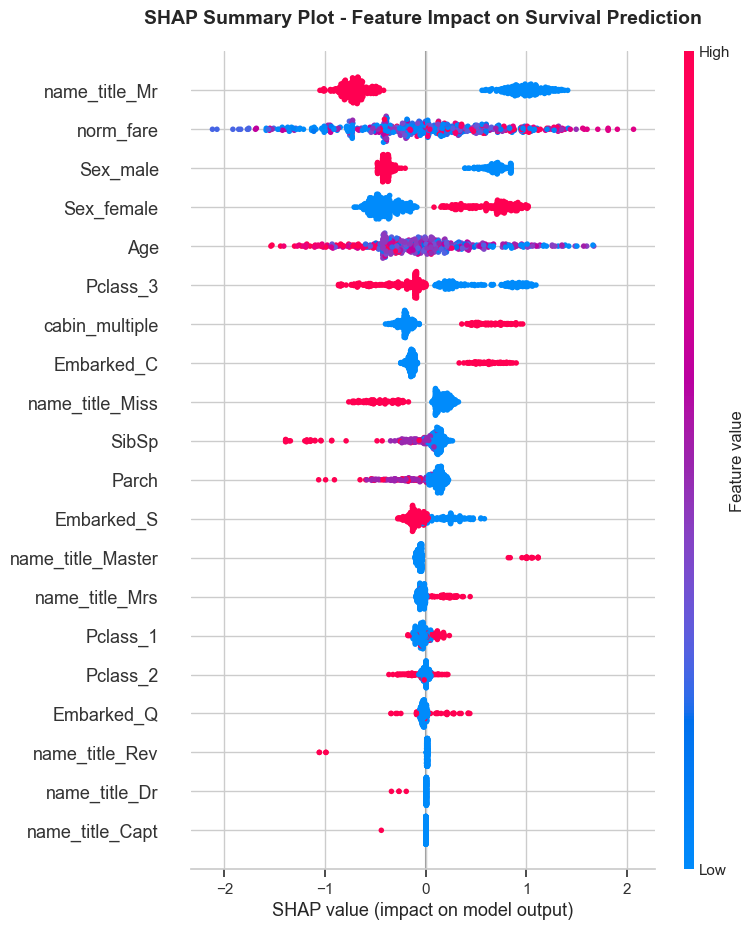


INTERPRETING THE SUMMARY PLOT:
• Features are ranked by importance (top = most important)
• Red points = high feature values, Blue points = low feature values
• Points to the right = push prediction toward Survived=1
• Points to the left = push prediction toward Survived=0


In [54]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))

# For binary classification, shap_values might be a list [class0, class1]
# We want class 1 (Survived=1) for interpretation
shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

shap.summary_plot(
    shap_values_plot, 
    X_sample,
    feature_names=X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else None,
    show=False
)
plt.title('SHAP Summary Plot - Feature Impact on Survival Prediction', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETING THE SUMMARY PLOT:")
print("="*70)
print("• Features are ranked by importance (top = most important)")
print("• Red points = high feature values, Blue points = low feature values")
print("• Points to the right = push prediction toward Survived=1")
print("• Points to the left = push prediction toward Survived=0")
print("="*70)


### 9.3 SHAP Bar Plot - Mean Absolute Feature Importance


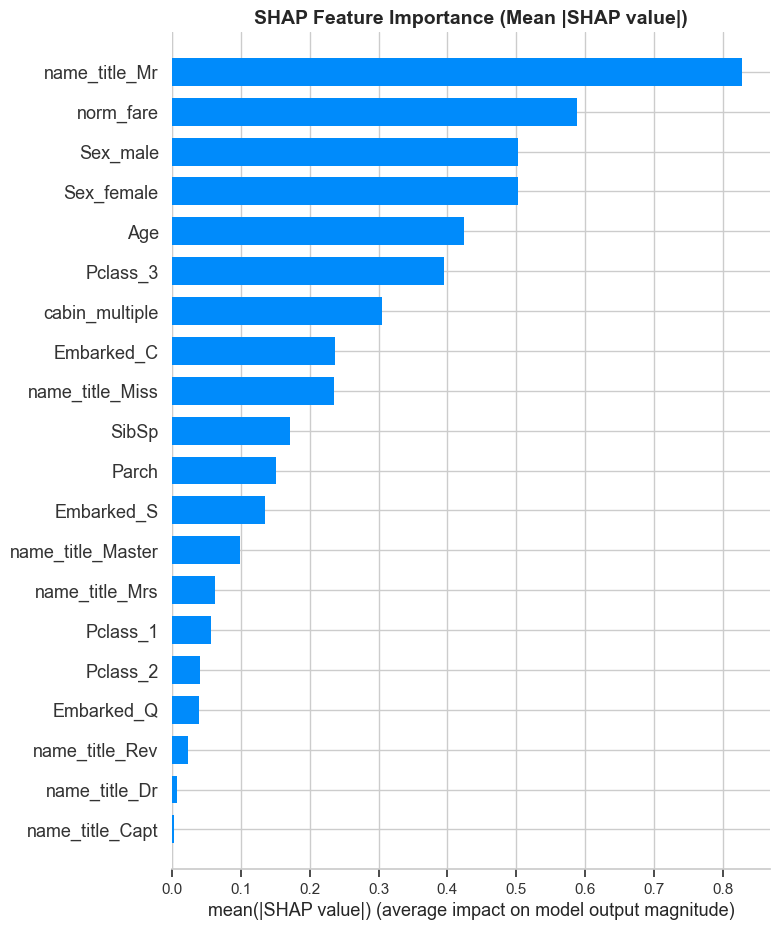

In [55]:
# SHAP Bar Plot
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values_plot,
    X_sample,
    plot_type="bar",
    feature_names=X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else None,
    show=False
)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 9.4 Individual Prediction Explanations - Waterfall Plots

Let's examine specific cases to understand model decisions:
- **Survived Passenger**: Why did the model predict survival?
- **Did Not Survive**: Why did the model predict death?


Found 199 predicted survivors and 301 predicted non-survivors in sample

EXAMPLE 1: Predicted Survivor (Index 1)

EXAMPLE 2: Predicted Non-Survivor (Index 0)


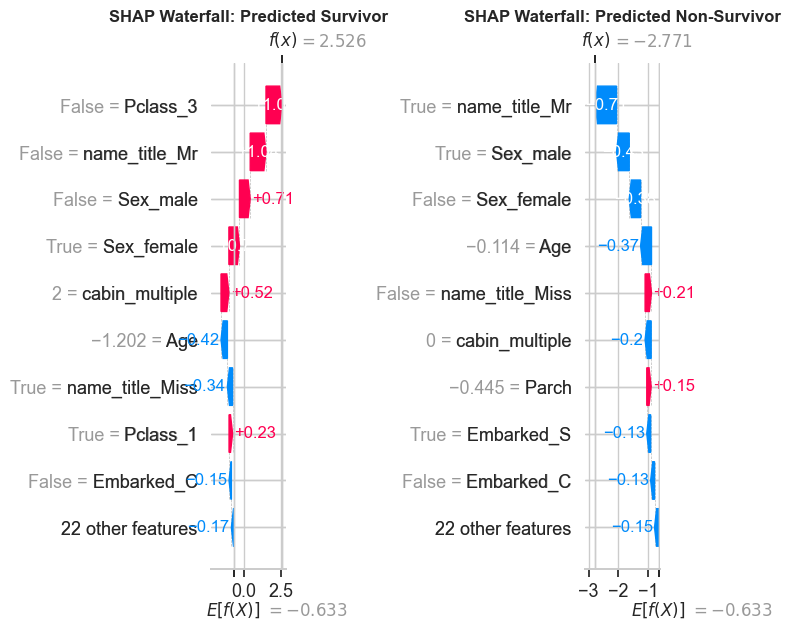


INTERPRETING WATERFALL PLOTS:
• E[f(x)] = Expected model output (baseline prediction)
• Red bars = Features pushing prediction UP (toward survival)
• Blue bars = Features pushing prediction DOWN (toward death)
• f(x) = Final model output for this passenger


In [56]:
# Get predictions for the sample
sample_predictions = model_for_shap.predict(X_sample)

# Find examples of survivors and non-survivors
survived_idx = np.where(sample_predictions == 1)[0]
died_idx = np.where(sample_predictions == 0)[0]

print(f"Found {len(survived_idx)} predicted survivors and {len(died_idx)} predicted non-survivors in sample")

# Select one example of each
survivor_example = survived_idx[0] if len(survived_idx) > 0 else 0
non_survivor_example = died_idx[0] if len(died_idx) > 0 else 1

# Create waterfall plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Waterfall plot for a survivor
print("\n" + "="*70)
print(f"EXAMPLE 1: Predicted Survivor (Index {survivor_example})")
print("="*70)
plt.sca(axes[0])

# For SHAP v0.41+, use Explanation objects
if hasattr(shap, 'Explanation'):
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_plot[survivor_example],
            base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
            data=X_sample.iloc[survivor_example] if isinstance(X_sample, pd.DataFrame) else X_sample[survivor_example],
            feature_names=X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else None
        ),
        show=False
    )
else:
    # Fallback for older versions
    shap.waterfall_plot(
        explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
        shap_values_plot[survivor_example],
        X_sample.iloc[survivor_example] if isinstance(X_sample, pd.DataFrame) else X_sample[survivor_example],
        feature_names=X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else None
    )

axes[0].set_title(f'SHAP Waterfall: Predicted Survivor', fontsize=12, fontweight='bold')

# Waterfall plot for non-survivor
print(f"\nEXAMPLE 2: Predicted Non-Survivor (Index {non_survivor_example})")
print("="*70)
plt.sca(axes[1])

if hasattr(shap, 'Explanation'):
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_plot[non_survivor_example],
            base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
            data=X_sample.iloc[non_survivor_example] if isinstance(X_sample, pd.DataFrame) else X_sample[non_survivor_example],
            feature_names=X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else None
        ),
        show=False
    )
else:
    shap.waterfall_plot(
        explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
        shap_values_plot[non_survivor_example],
        X_sample.iloc[non_survivor_example] if isinstance(X_sample, pd.DataFrame) else X_sample[non_survivor_example],
        feature_names=X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else None
    )

axes[1].set_title(f'SHAP Waterfall: Predicted Non-Survivor', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETING WATERFALL PLOTS:")
print("="*70)
print("• E[f(x)] = Expected model output (baseline prediction)")
print("• Red bars = Features pushing prediction UP (toward survival)")
print("• Blue bars = Features pushing prediction DOWN (toward death)")  
print("• f(x) = Final model output for this passenger")
print("="*70)


### 9.5 SHAP Dependence Plots - Feature Interactions

Dependence plots show how a single feature affects predictions across its range, and potentially how it interacts with another feature.



Top 2 features for dependence plots: ['name_title_Mr', 'Sex_female']


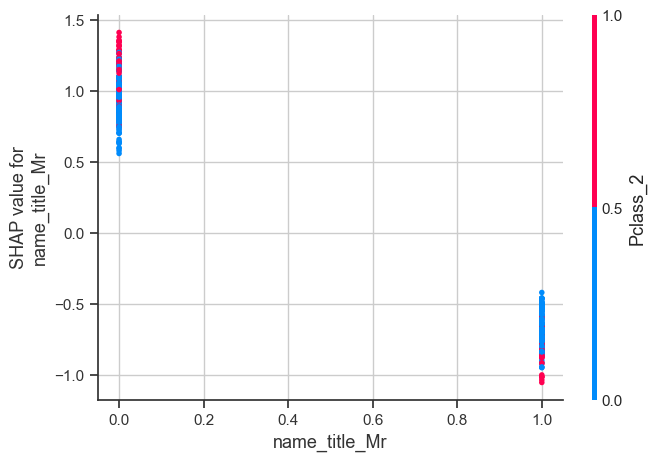

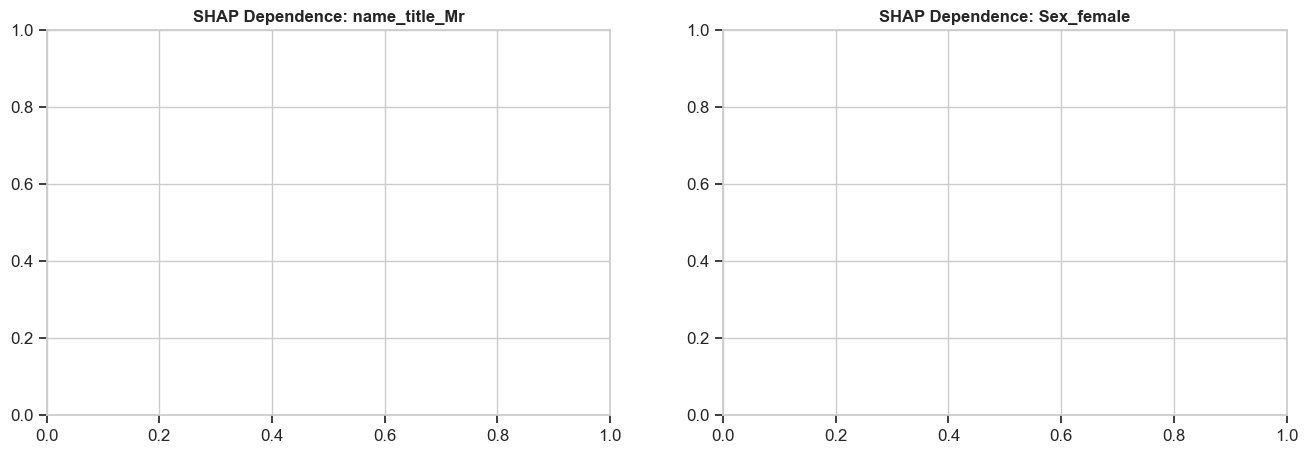

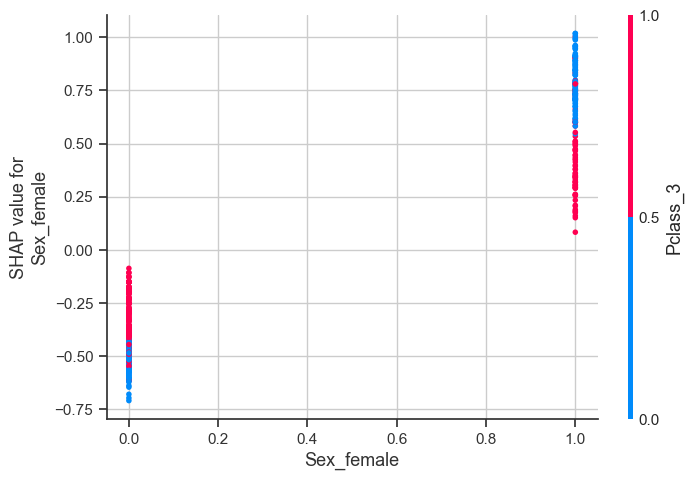


INTERPRETING DEPENDENCE PLOTS:
• X-axis: Feature value
• Y-axis: SHAP value (impact on prediction)
• Color: Another feature that interacts with this one
• Patterns reveal how feature affects survival prediction


In [57]:
# Get feature names
if isinstance(X_train_scaled, pd.DataFrame):
    feature_names = X_train_scaled.columns.tolist()
    
    # Find most important features for dependence plots
    # Get feature importances from the model
    if hasattr(model_for_shap, 'feature_importances_'):
        feature_importance = pd.Series(
            model_for_shap.feature_importances_,
            index=feature_names
        ).sort_values(ascending=False)
        
        # Select top 2 most important features for dependence plots
        top_features = feature_importance.head(2).index.tolist()
        
        print(f"\nTop 2 features for dependence plots: {top_features}")
        
        # Plot dependence for top 2 most important features
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        for i, feat in enumerate(top_features):
            feat_idx = feature_names.index(feat)
            plt.sca(axes[i])
            shap.dependence_plot(
                feat_idx,
                shap_values_plot,
                X_sample,
                feature_names=feature_names,
                show=False
            )
            axes[i].set_title(f'SHAP Dependence: {feat}', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*70)
        print("INTERPRETING DEPENDENCE PLOTS:")
        print("="*70)
        print("• X-axis: Feature value")
        print("• Y-axis: SHAP value (impact on prediction)")
        print("• Color: Another feature that interacts with this one")
        print("• Patterns reveal how feature affects survival prediction")
        print("="*70)
    else:
        print("Model does not have feature_importances_ attribute")
else:
    print("Dependence plots require feature names (DataFrame input)")


## 10. Production ML Pipeline

For deployment, we've created a production-ready sklearn Pipeline in `src/pipeline/train_pipeline.py` that:
- Encapsulates all preprocessing steps
- Ensures reproducibility
- Simplifies deployment
- Prevents data leakage

Let's demonstrate the pipeline approach alongside our notebook analysis.


In [58]:
# Import production pipeline
from src.pipeline.train_pipeline import TitanicTrainingPipeline, train_and_evaluate_pipeline

print("="*70)
print("PRODUCTION PIPELINE DEMONSTRATION")
print("="*70)

# Initialize pipeline with optimized XGBoost parameters
production_pipeline = TitanicTrainingPipeline(random_state=config.RANDOM_SEED)

# Train pipeline
print("\nTraining production pipeline...")
pipeline_results = production_pipeline.train(train, train['Survived'], cv_folds=5)

print("\n" + "="*70)
print("PIPELINE VS NOTEBOOK COMPARISON:")
print("="*70)
print(f"Notebook Best Model ({best_model_name}):")
print(f"  Cross-Val Score: {best_model_score:.4f}")
print(f"\nProduction Pipeline:")
print(f"  Cross-Val Score: {pipeline_results['cv_mean']:.4f}")
print(f"  Std Dev: {pipeline_results['cv_std']:.4f}")
print("="*70)

# Generate predictions with pipeline
pipeline_predictions = production_pipeline.predict(test)

# Compare predictions
agreement = np.mean(pipeline_predictions == best_model_preds)
print(f"\nPrediction Agreement: {agreement:.2%}")
print(f"  (How often both approaches agree on the same prediction)")

# Save production pipeline
print("\nSaving production pipeline...")
production_pipeline.save('titanic_production_pipeline.pkl', 'models')

print("\n✓ Production pipeline ready for deployment!")
print("  Load with: TitanicTrainingPipeline.load('titanic_production_pipeline.pkl')")


PRODUCTION PIPELINE DEMONSTRATION

Training production pipeline...
Training pipeline...
Training set size: 891 samples


[ 2025-11-05 17:41:43,973 ] 254 root - INFO - Model saved to models\titanic_production_pipeline.pkl



✓ Training complete!
  CV Accuracy: 0.8316 (+/- 0.0190)
  Individual fold scores: ['0.8603', '0.8427', '0.8034', '0.8258', '0.8258']

PIPELINE VS NOTEBOOK COMPARISON:
Notebook Best Model (Voting Classifier):
  Cross-Val Score: 0.8487

Production Pipeline:
  Cross-Val Score: 0.8316
  Std Dev: 0.0190

Prediction Agreement: 92.11%
  (How often both approaches agree on the same prediction)

Saving production pipeline...
File "titanic_production_pipeline.pkl" saved to <./models>
Pipeline saved to models/titanic_production_pipeline.pkl

✓ Production pipeline ready for deployment!
  Load with: TitanicTrainingPipeline.load('titanic_production_pipeline.pkl')
